# The Relationship Between Healthcare Spending & Diabetes (US)

<div>
<img src="Images/BeyondType1Logo.png" width="500">
<div>

# Overview

In this project, a combination of exploratory data analysis, regression modeling & classification modeling is used to determine whether the factors that determine healthcare expenses are the same for diabetics & non-diabetics. My conclusions on this question are then used to make actionable recommendations to the non-profit organization Beyond Type I. Additionally, this project seeks to provide a statistical answer on whether healthcare spending is similar between the two groups. 

Data in this project is sourced from the Medical Expenditure Panel Survey (MEPS), a nationally representative survey of the civilian noninstitutionalized population administered by the Agency for Healthcare Research and Quality. Specifically, this project's data is pulled from MEPS's annual [Household Full Year Consolidated Data Files](https://www.meps.ahrq.gov/mepsweb/data_stats/download_data_files_results.jsp?cboDataYear=All&cboDataTypeY=1%2CHousehold+Full+Year+File&buttonYearandDataType=Search&cboPufNumber=All&SearchTitle=Consolidated+Data).

# Problem

[Beyond Type I](https://beyondtype1.org/) is a nonprofit with a focus on education, advocacy & a path to cure Type I Diabetes. A primary focus of their advocacy is the added cost of living for those diagnosed with the condition.

Recently, they’ve aimed to put together a comprehensive report on the factors that determine how much income diabetic & non-diabetic citizens spend on healthcare. As part of the team working on the report, my task is to use regression modeling to answer the following question:

**Are the demographic factors (race, sex, education level, income level, age) most important to determining money spent on healthcare the same for diabetics & non-diabetics?**

# Importing Data & Libraries

In [1]:
# importing libraries & modules
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind, iqr
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesRegressor
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor

# making sure no columns are hidden in displays
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# assigning .csv names
list_of_names = ['fy00', 'fy01', 'fy02', 'fy03', 'fy04', 'fy05', 'fy06', 'fy07',
                'fy08', 'fy09', 'fy10', 'fy11', 'fy12', 'fy13', 'fy14', 'fy15',
                'fy16', 'fy17']

# creating empty list for new DataFrames
dataframes_list = []

# appending dataset into list
for i in range(len(list_of_names)):
    temp_df = pd.read_csv('Data_Notebook/'+list_of_names[i]+'.csv')
    temp_df.drop(columns='Unnamed: 0', axis=1, inplace=True)
    dataframes_list.append(temp_df)

In [3]:
# importing final year (2018) separately since it's in .xlsx format
df18 = pd.read_excel('Data_Notebook/h209.xlsx')

****

# Data Reformatting & Preprocessing

The initial list of columns to keep for each dataset was determined by reading through the codebook provided for each year's Household Full Year Consolidated Data File. Using the codebooks, I was able to determine which columns contained the relevant demographic, socioeconomic & healthcare expenditure data for this task. Additionally, I was able to determine which of these columns were common across all (or most) years 2000 - 2018, and which were not. 

For reference, the codebook from 2018 is provided [here](https://www.meps.ahrq.gov/data_stats/download_data/pufs/h209/h209cb.pdf).

## Reformatting

Of all the columns available to choose from, I ended up selecting those displayed in the **univ_cols** list below. 

These columns signify the following attributes of the survey's subject, respectively: 

* US geographical region 
* Age
* Sex
* Race/ethnicity
* Education level
* Total income for the given year
* Whether they had no usual source of care due to high healthcare costs
* Whether they had private insurance in the given year
* Whether they had Tricare insurance in the given year
* Whether they had Medicare insurance in the given year
* Whether they had Medicaid insurance in the given year
* Whether they have diabetes
* Whether they believe their insurance is not worth the cost they currently pay
* Total healthcare expenses for the given year
* Total emergency room expenses for the given year.

In [4]:
# the columns of interest for this project
univ_cols = ['REGION', 'AGE', 'SEX', 'RACETHX', 'EDU_LVL',
             'TTL_INC', 'INS_PRV', 'INS_TRI',
             'INS_MCR', 'INS_MCD', 'DIABDX',
             'HEALTH_EXP']

For years 2000 - 2004, the original columns are similarly named, so they can all work in the same FOR loop.

In [5]:
# years 2000 - 2004
for i in list(range(5)):
    
    # specifiying columns of interest for this project
    to_keep = [f'REGION0{i}', f'AGE0{i}X', 'SEX', 'RACETHNX', 'HIDEGYR',
               f'TTLP0{i}X', f'PRVEV0{i}', f'TRIEV0{i}',
               f'MCREV0{i}', f'MCDEV0{i}', 'DIABDX53',
               f'TOTEXP0{i}']
    
    # filtering based on chosen columns
    dataframes_list[i] = dataframes_list[i].loc[:,to_keep]
    
    # renaming columns for universality across all datasets
    dataframes_list[i].columns = univ_cols
    
    # adding a 'year' column for each year's dataset
    dataframes_list[i].insert(0, 'YEAR', int(f'200{i}'))

In 2005, the column *HIDEGYR* had its label changed to *HIDEG*.

In [6]:
# years 2005 & 2006
for i in list(range(5,7)):
    
    # specifiying columns of interest for this project
    to_keep = [f'REGION0{i}', f'AGE0{i}X', 'SEX', 'RACETHNX', 'HIDEG',
               f'TTLP0{i}X', f'PRVEV0{i}', f'TRIEV0{i}',
               f'MCREV0{i}', f'MCDEV0{i}', 'DIABDX53',
               f'TOTEXP0{i}']
    
    # filtering based on chosen columns
    dataframes_list[i] = dataframes_list[i].loc[:,to_keep]
    
    # renaming columns for universality across all datasets
    dataframes_list[i].columns = univ_cols
    
    # adding a 'year' column for each year's dataset
    dataframes_list[i].insert(0, 'YEAR', int(f'200{i}'))

In 2007, the column *DIABDX53* had its label changed to *DIABDX*.

In [7]:
# years 2007 - 2009
for i in list(range(7,10)):
    
    # specifiying columns of interest for this project
    to_keep = [f'REGION0{i}', f'AGE0{i}X', 'SEX', 'RACETHNX', 'HIDEG',
               f'TTLP0{i}X', f'PRVEV0{i}', f'TRIEV0{i}',
               f'MCREV0{i}', f'MCDEV0{i}', 'DIABDX',
               f'TOTEXP0{i}']
    
    # filtering based on chosen columns
    dataframes_list[i] = dataframes_list[i].loc[:,to_keep]
    
    # renaming columns for universality across all datasets
    dataframes_list[i].columns = univ_cols
    
    # adding a 'year' column for each year's dataset
    dataframes_list[i].insert(0, 'YEAR', int(f'200{i}'))

In [8]:
# years 2010 & 2011
for i in list(range(10,12)):
    
    # specifiying columns of interest for this project
    to_keep = [f'REGION{i}', f'AGE{i}X', 'SEX', 'RACETHNX', 'HIDEG',
               f'TTLP{i}X', f'PRVEV{i}', f'TRIEV{i}',
               f'MCREV{i}', f'MCDEV{i}', 'DIABDX',
               f'TOTEXP{i}']
    
    # filtering based on chosen columns
    dataframes_list[i] = dataframes_list[i].loc[:,to_keep]
    
    # renaming columns for universality across all datasets
    dataframes_list[i].columns = univ_cols
    
    # adding a 'year' column for each year's dataset
    dataframes_list[i].insert(0, 'YEAR', int(f'20{i}'))

In 2012, the column *RACETHNX* had its label changed to *RACETHX*.

In [9]:
# for year 2012: specifiying columns of interest
to_keep = ['REGION12', 'AGE12X', 'SEX', 'RACETHX', 'HIDEG',
           'TTLP12X', 'PRVEV12', 'TRIEV12', 'MCREV12',
           'MCDEV12', 'DIABDX', 'TOTEXP12']
    
# filtering based on chosen columns
dataframes_list[12] = dataframes_list[12].loc[:,to_keep]
    
# renaming columns for universality across all datasets
dataframes_list[12].columns = univ_cols
    
# adding a 'year' column
dataframes_list[12].insert(0, 'YEAR', 2012)

For 2013 & 2014, the column *HIDEG* had its label changed to *EDUYRDG*.

In [10]:
# years 2013 & 2014
for i in list(range(13,15)):
    
    # specifiying columns of interest for this project
    to_keep = [f'REGION{i}', f'AGE{i}X', 'SEX', 'RACETHX', 'EDUYRDG',
               f'TTLP{i}X', f'PRVEV{i}', f'TRIEV{i}',
               f'MCREV{i}', f'MCDEV{i}', 'DIABDX',
               f'TOTEXP{i}']
    
    # filtering based on chosen columns
    dataframes_list[i] = dataframes_list[i].loc[:,to_keep]
    
    # renaming columns for universality across all datasets
    dataframes_list[i].columns = univ_cols
    
    # adding a 'year' column for each year's dataset
    dataframes_list[i].insert(0, 'YEAR', int(f'20{i}'))

From 2015 on, the column *EDUYRDG* had its label changed back to *HIDEG*.

In [11]:
# years 2015 - 2017
for i in list(range(15,18)):
    
    # specifiying columns of interest for this project
    to_keep = [f'REGION{i}', f'AGE{i}X', 'SEX', 'RACETHX', 'HIDEG',
               f'TTLP{i}X', f'PRVEV{i}', f'TRIEV{i}',
               f'MCREV{i}', f'MCDEV{i}', 'DIABDX',
               f'TOTEXP{i}']
    
    # filtering based on chosen columns
    dataframes_list[i] = dataframes_list[i].loc[:,to_keep]
    
    # renaming columns for universality across all datasets
    dataframes_list[i].columns = univ_cols
    
    # adding a 'year' column for each year's dataset
    dataframes_list[i].insert(0, 'YEAR', int(f'20{i}'))

In 2018, the column *DIABDX*  had its label changed to *DIABDX_M18*.

In [12]:
# updating universal columns since ADINSB42 removed from MEPS survey
univ_cols = ['REGION', 'AGE', 'SEX', 'RACETHX', 'EDU_LVL',
             'TTL_INC', 'INS_PRV', 'INS_TRI', 'INS_MCR',
             'INS_MCD', 'DIABDX', 'HEALTH_EXP']


# for year 2018: specifiying columns of interest
to_keep = ['REGION18', 'AGE18X', 'SEX', 'RACETHX', 'HIDEG',
           'TTLP18X', 'PRVEV18', 'TRIEV18', 'MCREV18', 'MCDEV18',
           'DIABDX_M18', 'TOTEXP18']
    
# filtering based on chosen columns
df18 = df18.loc[:,to_keep]
    
# renaming columns for universality across all datasets
df18.columns = univ_cols
    
# adding a 'year' column
df18.insert(0, 'YEAR', 2018)

Now, I combine all of the datasets in **dataframes_list** & **df_18** into one DataFrame spanning 19 years.

In [13]:
# combining datasets 2000-2017
df = pd.concat(dataframes_list)

In [14]:
# adding 2018's data to dataframe
df = pd.concat([df, df18])

In [15]:
# taking a look at the results
df.head()

,YEAR,REGION,AGE,SEX,RACETHX,EDU_LVL,TTL_INC,INS_PRV,INS_TRI,INS_MCR,INS_MCD,DIABDX,HEALTH_EXP
0,2000,1,76,2,2,1,11699.0,2,2,1,2,2,1419
1,2000,1,51,1,3,4,83753.0,1,2,2,2,2,1160
2,2000,1,47,2,3,3,39527.0,1,2,2,2,2,1743
3,2000,1,24,2,3,3,20800.0,1,2,2,2,2,313
4,2000,1,22,2,3,3,7020.0,1,2,2,2,2,570


## Preprocessing

### Inspecting, Adjusting & Standardizing Column Values

In this section, I inspect all columns in the dataset and perform at least one of the following:

* List unique values
* Show count/distribution of each value in column
* Explain the meaning of column values (provided by the MEPS codebooks)
* Filter, reassign and/or drop values based on heuristics

#### Age

This study aims to analyze, in part, how a person's income & healthcare expenses are related. Therefore, the scope of the data is narrowed to people of working age (18-65). 

In [16]:
# filtering dataset to include only survey subjects of working age
df = df.loc[(df['AGE'] >= 18) & (df['AGE'] <= 65)]

#### Year

In [17]:
# listing years in the dataset
df['YEAR'].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])

In [18]:
# distribution of data across years 2000-2018
df.groupby('YEAR')['HEALTH_EXP'].count()

YEAR
2000    14896
2001    20138
2002    23326
2003    20099
2004    20362
2005    20104
2006    20156
2007    18504
2008    20042
2009    22455
2010    20005
2011    21510
2012    23891
2013    22614
2014    21221
2015    21538
2016    20904
2017    18978
2018    17745
Name: HEALTH_EXP, dtype: int64

#### Region

The values for the *REGION* column are as follows:

* 1 - Northeast
* 2 - Midwest
* 3 - South
* 4 - West
* -1 - Inapplicable

In [19]:
# listing region column values
df['REGION'].unique()

array([ 1,  4,  3,  2, -1])

In [20]:
# distribution of data across regions
df['REGION'].value_counts()

 3    147791
 4    104875
 2     75755
 1     60063
-1         4
Name: REGION, dtype: int64

#### Sex

The values for the *SEX* column are as follows:

* 1 - Male
* 2 - Female

In [21]:
# listing sex column values
df['SEX'].unique()

array([1, 2])

I choose to subtract 1 from all entries of the column so that it is instead displaying the usual 0-1 numerical binary. 

Now, the values for the *SEX* column are as follows:

* 0 - Male
* 1 - Female

In [22]:
# changing to 0-1 binary
df['SEX'] -= 1

In [23]:
# distribution of data across sex
df['SEX'].value_counts()

1    205584
0    182904
Name: SEX, dtype: int64

#### Race / Ethnicity

The values for the *RACETHX* column are different across various years.

2000 & 2001:
* 1 - Hispanic
* 2 - Black (non-Hispanic)
* 3 - Other

2002 - 2011:
* 1 - Hispanic
* 2 - Black (non-Hispanic)
* 3 - Asian (non-Hispanic)
* 4 - Other

2012 - 2018:
* 1 - Hispanic
* 2 - White (non-Hispanic)
* 3 - Black (non-Hispanic)
* 4 - Asian (non-Hispanic)
* 5 - Other

In [24]:
# listing race/ethnicity column values
df['RACETHX'].unique()

array([3, 1, 2, 4, 5])

Because there are only 3 categories common among all years ("Hispanic," "Black (non-Hispanic)," & "Other"), I choose to make this categorization the standard across the entire dataset. This first requires reorienting the values for years 2012-2018 (where Black non-Hispanic is not listed in its usual value *2*) before standardizing across all years.

Though it would be ideal to have a more thorough list of groups, this should give at least some insight into the healthcare spending of the two largest minority groups in the US.

The values for the *RACETHX* column are now as follows:

* 0 - Other
* 1 - Hispanic
* 2 - Black (non-Hispanic)

In [25]:
# dictionary to make 2012-2018 values the same as those from 2002-2011
dict_1218 = {1:1, 2:4, 3:2, 4:3, 5:4}

# remapping 2012-2018 values based on dictionary 
df.loc[((df['YEAR'] >= 2012) | (df['YEAR'] <= 2018)), 'RACETHX'] = \
    df.loc[((df['YEAR'] >= 2012) | (df['YEAR'] <= 2018)), 'RACETHX'].map(dict_1218)

# final dictionary to reassign values across ALL years
racethx_dict = {1:1, 2:2, 3:0, 4:0, 5:0}

# values finally set as laid out in markdown above 
df.replace({'RACETHX': racethx_dict}, inplace=True)

In [26]:
# distribution of data across available race/ethnicity categories
df['RACETHX'].value_counts()

0    220627
1    106248
2     61613
Name: RACETHX, dtype: int64

#### Education Level

The values for the *EDU_LVL* column are different across various years.

2000 - 2012, 2015 - 2017:
* -9 - Not Ascertained
* -8 - Don't Know
* -7 - Refused
* -1 - Inapplicable 
* 1 - No Degree
* 2 - GED
* 3 - High School Diploma
* 4 - Bachelor's Degree
* 5 - Master's Degree
* 6 - Doctorate Degree
* 7 - Other Degree
* 8 - Under 16-Inapplicable

2013 & 2014:
* -9 - Not Ascertained
* -8 - Don't Know
* -7 - Refused
* -1 - Inapplicable
* 1 - Less Than/Equal To 8th Grade
* 2 - 9-12th Grade, no High School Diploma
* 3 - GED or Equivalent
* 4 - High School Diploma
* 5 - Some College, No Degree
* 6 - Associate Degree: Occupational, Tech, Vocational
* 7 - Associate Degree: Academic Program
* 8 - Bachelor's Degree (BA, AB, BS, BBA)
* 9 - Master's, Professional, Doctoral Degree
* 10 - Child Under 5 Years Old

2018:
* -15 - Cannot Be Computed
* -8 - Don't Know
* -7 - Refused
* 1 - No Degree
* 2 - GED
* 3 - High School Diploma
* 4 - Bachelor's Degree
* 5 - Master's Degree
* 6 - Doctorate Degree
* 7 - Other Degree
* 8 - Under 16-Inapplicable

In [27]:
# listing education level column values
sorted(df['EDU_LVL'].unique())

[-15, -9, -8, -7, -1, 1, 2, 3, 4, 5, 6, 7, 8, 9]

As seen above, the years 2013 & 2014 follow a different convention for education level values compared to other years. Below, I reassign the positive values for those specific years so that they match up with the others. 

In [28]:
# creating dictionary to remap 2013, 2014 column values
edu_dict = {1:1, 2:1, 3:2, 4:3, 5:3, 6:3, 7:3, 8:4, 9:5, 10:-10}

# remapping values from 2013, 2014 so that they're in line with other years
df.loc[((df['YEAR'] == 2013) | (df['YEAR'] == 2014)), 'EDU_LVL'] = \
    df.loc[((df['YEAR'] == 2013) | (df['YEAR'] == 2014)), 'EDU_LVL'].map(edu_dict)

In [29]:
sorted(df['EDU_LVL'].unique())

[-15.0, -9.0, -8.0, -7.0, -1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]

I remember seeing in 2015's codebook that a significant portion of the year's values fall under **-1 - "Inapplicable"**, but I want to see if the other negative values take up a sizable portion of the data. 

In [30]:
# calculating how many entries are part of "Cannot Be Computed," "Don't Know" or "Refused" categories
not_of_interest = df.loc[df['EDU_LVL'] < -1]
print('% of entries not in categories -1 thru 7:',
      f'{(len(not_of_interest.EDU_LVL) / len(df.EDU_LVL))*100}%')
print(f'Total entries not in categories: {len(not_of_interest.EDU_LVL)}')

% of entries not in categories -1 thru 7: 0.8121228969749388%
Total entries not in categories: 3155


In [31]:
# displaying % of dataset entries that are null
print('% of entries that are null:')
(df['EDU_LVL'].isna().sum() / len(df['EDU_LVL']))*100

% of entries that are null:


0.17297831593253846

In [32]:
# checking how large the dataset is before filtering
df.shape

(388488, 13)

Because less than 1% of the 388,488 current dataset entries are in the "Cannot Be Computed," "Don't Know," or "Refused" responses (or are null entries), I go ahead and drop them. 

I do keep the **-1 - "Inapplicable"** response, though, since it is the category under which about half of 2015's data falls under.

In [33]:
# showing how many entries from 2015 have EDU_LVL of -1
df_15 = df.loc[df['YEAR'] == 2015]
prop = (len(df_15[df_15['EDU_LVL'] == -1]['EDU_LVL']) / len(df_15['EDU_LVL']))*100
print(f'% of 2015 entries with value of -1: {prop}%')

% of 2015 entries with value of -1: 45.57990528368465%


In [34]:
# filtering out responses specified above
df = df.loc[df['EDU_LVL'] >= -1]

# dropping null values from column
df.dropna(subset=['EDU_LVL'], inplace=True)

In [35]:
# distribution of data across education levels
df['EDU_LVL'].value_counts()

 3.0    162940
 1.0     79847
 4.0     53560
 7.0     23585
-1.0     22529
 5.0     21179
 2.0     16324
 6.0      4697
Name: EDU_LVL, dtype: int64

#### Annual Income

Since there will obviously be too many unique income values to count, let's instead take a more large-scale look at the annual income values across the dataset. 

In [36]:
# statistical breakdown of income values
df['TTL_INC'].describe()

count    384661.000000
mean      29779.175679
std       33082.716783
min     -309948.000000
25%        8000.000000
50%       20800.000000
75%       40200.000000
max      731653.000000
Name: TTL_INC, dtype: float64

Before filtering these values, I realize that determining a reasonable lower cutoff point could be beneficial to future analysis. 

Since my initial selection criteria was "subjects who are of working age" (18-65 years old), this leaves room for unsreasonably low income values from, for instance, young adults who are still dependents but earn money in a more limited capacity. 

To make sure that my analysis does not overlook independent, poorer workers, though, I choose to take the earliest (year 2000), lowest (provided by [Connecticut General Assembly](https://www.cga.ct.gov/2000/rpt/2000-R-0393.htm)) federally mandated minimum wage of 5.15 USD/hr and calculate an annual income from a 40 hr/wk, 52 week work year.

This method gives an annual income value of 10,712 USD. I inspect the dataset to see how many entries fall below and above this threshold

In [37]:
# data below threshold
lower = df.loc[df['TTL_INC'] < 10712]

# how many entries in this group
lower.shape

(119262, 13)

In [38]:
# how many entires at/above threshold
df.loc[df['TTL_INC'] >= 10712].shape

(265399, 13)

In [39]:
# displaying what % of data falls below threshold
frac = len(lower['TTL_INC']) / len(df['TTL_INC'])
print('% of entries that fall below the threshold:')
print(f'{(frac)*100}%')

% of entries that fall below the threshold:
31.004442873075256%


Though losing 31% of entries is a significant loss of what I'm currently working with, I believe that a dataset of over 265,000 entries will be sufficient for regression training & modeling. Just to be certain, though, I look at the entry counts for each year to make sure there's no massive imbalance among them.

In [40]:
# displaying entry counts at/above income threshold for each year 
df.loc[df['TTL_INC'] >= 10712].groupby('YEAR')['TTL_INC'].count()

YEAR
2000    10371
2001    14041
2002    15853
2003    13291
2004    13511
2005    13523
2006    13683
2007    12720
2008    13850
2009    15153
2010    13394
2011    14290
2012    15954
2013    15050
2014    14347
2015    15040
2016    14725
2017    13560
2018    13043
Name: TTL_INC, dtype: int64

Though the data isn't perfectly balanced, no year has a greater degree of entries than the rest, which is sufficient for me.

In [41]:
# filtering main dataframe
df = df.loc[df['TTL_INC'] >= 10712]

In [42]:
# statistical summary after filter lower end
df['TTL_INC'].describe()

count    265399.000000
mean      41604.558544
std       33575.983641
min       10712.000000
25%       20000.000000
50%       31317.000000
75%       51000.000000
max      731653.000000
Name: TTL_INC, dtype: float64

#### Subject Had the Following Insurance Plans in The Last Year

I inspect the values in the columns that indicate whether a survey subject had a private, Tricare, Medicaid or Medicare insurance plan in a given year.

In [43]:
# private insurance
df['INS_PRV'].unique()

array([1, 2])

In [44]:
# tricare insurance
df['INS_TRI'].unique()

array([2, 1])

In [45]:
# medicaid
df['INS_MCD'].unique()

array([2, 1])

In [46]:
# medicare
df['INS_MCR'].unique()

array([2, 1])

The values for these columns signify: 

* 1 - Yes
* 2 - No

#### Subject Has Diabetes

I inspect the values in the column that indicate whether a survey subject has diabetes or not.

In [47]:
# listing diabetes status column values
df['DIABDX'].unique()

array([ 2,  1, -7, -8, -1, -9])

In [48]:
# displaying % of responses that are not "Yes" or "No"
print('% of responses outside of "Yes/No":')
print(f'{(len(df.loc[df.DIABDX < 0].DIABDX) / len(df.DIABDX))*100}%')

% of responses outside of "Yes/No":
0.26262344620740846%


In [49]:
# filtering so that all data falls into 'Yes' or 'No'
df = df.loc[df.DIABDX > 0]

In [50]:
# distribution of 'Yes's & 'No's
df['DIABDX'].value_counts(normalize=True)

2    0.933351
1    0.066649
Name: DIABDX, dtype: float64

#### Target Column *HEALTH_EXP*

Finally, a look at the annual healthcare expenditure column, *HEALTH_EXP*:

In [51]:
# statistical description of healthcare expenditure column
df['HEALTH_EXP'].describe()

count    264702.00000
mean       3305.02425
std       10854.35203
min           0.00000
25%          75.00000
50%         656.00000
75%        2586.00000
max      966587.00000
Name: HEALTH_EXP, dtype: float64

It's already evident that this healthcare expense data is heavily right-skewed. Not only is the standard deviation about 3 times as large as the mean, but the mean itself is a whole degree larger than the median.

<AxesSubplot:>

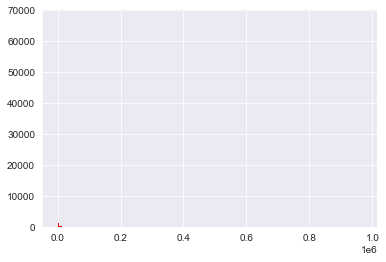

In [52]:
df['HEALTH_EXP'].hist(bins='auto', color='r', lw=0)

If nothing else, this is a clear sign that a cutoff must be put in place for upper outliers to be eliminated, since these values will make it difficult to build an effective model later on.

I began by considering a *75th percentile + 1.5IQR* upper threshold over *mean + 3 standard deviations*, since the former seems to be more impervious to skew than the latter. But I choose the less destructive mean / standard deviation method, reserving bigger changes for later if necessary.

In [53]:
# statistical summary of healthcare expenses for non-diabetics
df.loc[df['DIABDX'] == 1]['HEALTH_EXP'].describe()

count     17642.000000
mean       9215.454654
std       19814.403965
min           0.000000
25%        1238.000000
50%        3576.500000
75%        9030.500000
max      550741.000000
Name: HEALTH_EXP, dtype: float64

In [54]:
# statistical summary of healthcare expenses for non-diabetics
df.loc[df['DIABDX'] == 2]['HEALTH_EXP'].describe()

count    247060.000000
mean       2882.973683
std        9773.608968
min           0.000000
25%          52.000000
50%         570.000000
75%        2247.000000
max      966587.000000
Name: HEALTH_EXP, dtype: float64

In [55]:
# calculating upper threshold for expenditure values
upper_cutoff = 2586 + 1.5*(iqr(df['HEALTH_EXP']))

# displaying % of data at or above cutoff point
print(f'Threshold value: {upper_cutoff}')
print('% of data at/above threshold:')
print(f'{(len(df.loc[df.HEALTH_EXP >= upper_cutoff].HEALTH_EXP) / len(df.HEALTH_EXP))*100}% \n')

# comparison of diabetic / non-diabetic counts, overall & above threshold
df_up = df.loc[df['HEALTH_EXP'] >= upper_cutoff]
print(f'Value counts overall: \n{df.DIABDX.value_counts(normalize=True)} \n')
print(f'Value counts above spending threshold: \n{df_up.DIABDX.value_counts(normalize=True)}')

Threshold value: 6352.5
% of data at/above threshold:
11.797795256552652% 

Value counts overall: 
2    0.933351
1    0.066649
Name: DIABDX, dtype: float64 

Value counts above spending threshold: 
2    0.810721
1    0.189279
Name: DIABDX, dtype: float64


In [56]:
# calculating mean + 3 standard deviations upper threshold
upper_cutoff = df['HEALTH_EXP'].mean() + 3*df['HEALTH_EXP'].std()

# displaying % of data at or above new cutoff point
print(f'Threshold value: {upper_cutoff}')
print('% of data at/above threshold:')
print(f'{(len(df.loc[df.HEALTH_EXP >= upper_cutoff].HEALTH_EXP) / len(df.HEALTH_EXP))*100}% \n')

Threshold value: 35868.08033968147
% of data at/above threshold:
1.3316861980642383% 



In [57]:
# filtering data to include only healthcare expenses below threshold
df = df.loc[df['HEALTH_EXP'] < upper_cutoff]

### Standardizing Binary Column Values

Currently, all questions with binary responses follow the same convention for dataset values -- 1 corresponds to "Yes" & 2 corresponds to "No." For modeling, though, I need to keep "Yes" as a 1 & convert "No" to a 0.

In [58]:
# creating dictionary to change "No" from 2 to 0
binary_dict = {2:0}

# listing columns that need to change their "No" value
binary_cols = ['INS_PRV', 'INS_TRI', 'INS_MCR', 'INS_MCD', 'DIABDX']

# making the change for binary_cols
for i in binary_cols:
    df.replace({i: binary_dict}, inplace=True)

In [59]:
df.head()

,YEAR,REGION,AGE,SEX,RACETHX,EDU_LVL,TTL_INC,INS_PRV,INS_TRI,INS_MCR,INS_MCD,DIABDX,HEALTH_EXP
1,2000,1,51,0,2,4.0,83753.0,1,0,0,0,0,1160
2,2000,1,47,1,2,3.0,39527.0,1,0,0,0,0,1743
3,2000,1,24,1,2,3.0,20800.0,1,0,0,0,0,313
6,2000,4,30,0,1,1.0,14000.0,1,0,0,0,0,0
7,2000,4,28,1,2,1.0,26000.0,1,0,0,0,0,155


****

# EDA & Visualizations

In this section, I compare and contrast the healthcare spending of diabetics & non-diabetics across time and within different US demographic subsets. This is done by calculating relevant statistics and creating visualizations of spending data for each group. Thus, it makes sense to initially split my dataset into diabetic & non-diabetic groups, since both are observed within each demographic subset.

In [60]:
# dataset of those who have diabetes
df_y = df.loc[df['DIABDX'] == 1]

# dataset of those who do NOT have diabetes
df_n = df.loc[df['DIABDX'] == 0]

## General Healthcare Spending for Diabetics & Non-Diabetics

### Diabetics

Below is a statistical description of annual healthcare expenses for diabetics (count: 16,732).

In [61]:
# creating a series of annual health expenses for diabetics
healthcare_dia = df_y['HEALTH_EXP']

In [62]:
# statistical summary of healthcare spending for diabetics 2000 - 2018
healthcare_dia.describe()

count    16732.000000
mean      5838.283768
std       6975.362565
min          0.000000
25%       1140.000000
50%       3231.500000
75%       7630.000000
max      35849.000000
Name: HEALTH_EXP, dtype: float64

Next, I plot a histogram of this annual expense data.

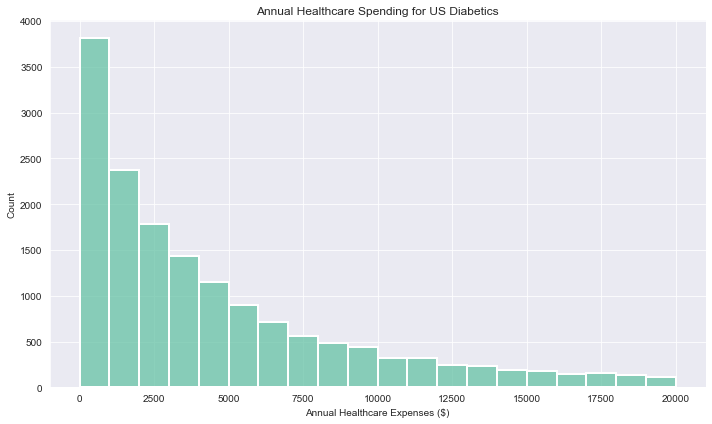

In [63]:
# plotting histogram of spending data for diabetics 
plt.figure(figsize=(10,6), tight_layout=True)
bins = np.linspace(0,20000, 21)

ax = sns.histplot(data=healthcare_dia, bins=bins, 
                  color=sns.color_palette('Set2')[0], linewidth=2)
ax.set_title('Annual Healthcare Spending for US Diabetics')
ax.set_xlabel('Annual Healthcare Expenses ($)')
ax.set_ylabel('Count')

plt.show()

The distribution of diabetic spending data is similar to the spending data of the whole group: it is zero-heavy and has a significant right skew.

### Non-Diabetics

Below is a statistical description of annual healthcare expenses for non-diabetics (count: 244,445).

In [64]:
# creating a series of annual health expenses for non-diabetics
healthcare_nondia = df_n['HEALTH_EXP']

In [65]:
# statistical summary of healthcare spending for non-diabetics 2000 - 2018
healthcare_nondia.describe()

count    244445.000000
mean       2168.451709
std        4300.873614
min           0.000000
25%          50.000000
50%         551.000000
75%        2146.000000
max       35868.000000
Name: HEALTH_EXP, dtype: float64

Next, I plot a histogram of this annual expense data.

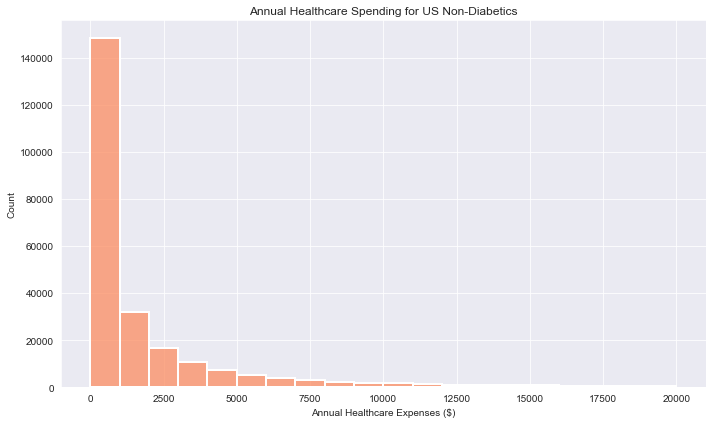

In [66]:
# plotting histogram of spending data for diabetics 
plt.figure(figsize=(10,6), tight_layout=True)
bins = np.linspace(0,20000, 21)

ax = sns.histplot(data=healthcare_nondia, bins=bins, 
                  color=sns.color_palette('Set2')[1], linewidth=2)
ax.set_title('Annual Healthcare Spending for US Non-Diabetics')
ax.set_xlabel('Annual Healthcare Expenses ($)')
ax.set_ylabel('Count')

plt.show()

Compared to the previous histogram, this one seems much more zero-heavy based on appearances. Like the other, though, it also has a significat right skew.

### Comparison & Statistical Testing

For comparison, I print out the mean & median of annual healthcare spending for both groups. 

In [67]:
print('Mean annual expenditure on healthcare for non-diabetics, 2000-2018:')
print(f'${healthcare_nondia.mean()}')
print('Median annual expenditure on healthcare for non-diabetics, 2000-2018:')
print(f'${healthcare_nondia.median()} \n')

print('Mean annual expenditure on healthcare for diabetics, 2000-2018:')
print(f'${healthcare_dia.mean()}')     
print('Median annual expenditure on healthcare for diabetics, 2000-2018:')
print(f'${healthcare_dia.median()}')

Mean annual expenditure on healthcare for non-diabetics, 2000-2018:
$2168.4517089733886
Median annual expenditure on healthcare for non-diabetics, 2000-2018:
$551.0 

Mean annual expenditure on healthcare for diabetics, 2000-2018:
$5838.283767630887
Median annual expenditure on healthcare for diabetics, 2000-2018:
$3231.5


Next, I perform a two-sample t-test with the null hypothesis that the diabetic & non-diabetic groups have identical expected values. A sufficiently small p-value & rejection of this null will provide evidence that these two groups spend different amounts on healthcare.

In [68]:
# a function that tests for the null hypothesis that both groups have identical average (expected) values
def ttest_diff(sample1, sample2):
    """
    Performs a two-sample t-test with the null hypothesis that 
    both groups/samples have identical average (expected) values.
    Test is performed using ttest_ind from scipy library.
    """
    # ttest_ind from scipy library
    ttest,pval = ttest_ind(sample1,sample2, equal_var=False)

    # displaying p-value
    print('t-test p-value:', pval)

    # displaying test result based on p-value
    if pval <0.05: 
        print('Reject null hypothesis that there is no difference b/t populations')
    else:
        print('Fail to reject null hypothesis that there is no difference b/t populations')
        
# running the new function with the diabetic, non-diabetic samples
ttest_diff(healthcare_dia, healthcare_nondia)

t-test p-value: 0.0
Reject null hypothesis that there is no difference b/t populations


## How Have Healthcare Costs Changed from 2000-2018?

In this section, I construct line plots of median healthcare expenditures for each year for both diabetics & non-diabetics. The first subsection looks at the target *HEALTH_EXP* figure -- in other words, the raw dollar spending amount. The second subsection looks at healthcare spending as a percentage of a person's income, indicated by the newly created *PERC_HEALTH*.

### Raw Dollars Spent on Healthcare Annually, 2000 - 2018:

In [69]:
# creating a two-column dataframe with both sets of annual expenditure data
df_usd = pd.DataFrame(columns = ['Diabetic', 'NonDiabetic'])
df_usd['Diabetic'] = df_y.groupby('YEAR')['HEALTH_EXP'].median()
df_usd['NonDiabetic'] = df_n.groupby('YEAR')['HEALTH_EXP'].median()

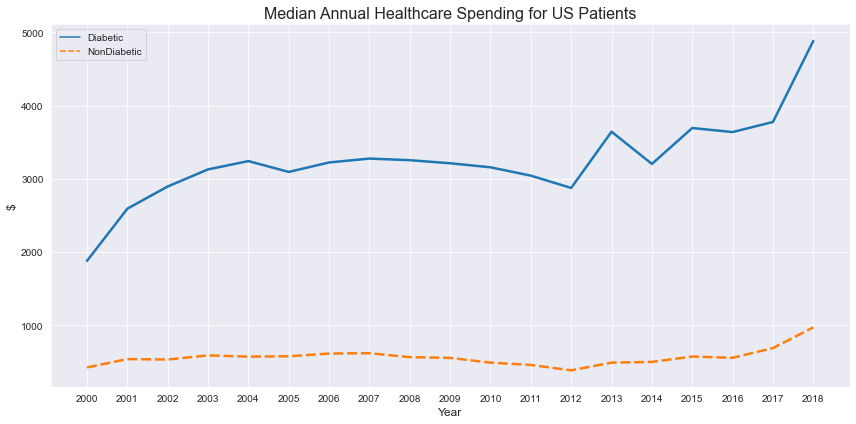

In [70]:
# displaying lineplots of annual healthcare expenditure for both groups
plt.figure(figsize=(12, 6), tight_layout=True)

ax = sns.lineplot(data=df_usd, linewidth=2.5)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('$', fontsize=12)
ax.set_title('Median Annual Healthcare Spending for US Patients', fontsize=16)
ax.set_xticks(list(range(2000, 2019)))

# plt.savefig('SpendingGap.png')
plt.show()

The above plot gives a good visual on the spending difference between the two groups. Additionally, both groups' annual healthcare expenditures seem to trend updwards over the 19 years covered. 

To end this subsection, I calculate the increase in spending difference from 2000 to 2018.

In [71]:
# spending gap b/t both groups at year 2000
start_gap = df_usd.loc[2000,'Diabetic'] - df_usd.loc[2000,'NonDiabetic']
# spending gap b/t both groups at year 2018
end_gap = df_usd.loc[2018,'Diabetic'] - df_usd.loc[2018,'NonDiabetic']

# increase from 2000-2018
print('Median Annual Spending Gap Increase from 2000 to 2018:')
print(f'+${end_gap - start_gap}')

Median Annual Spending Gap Increase from 2000 to 2018:
+$2456.5


### Percentage of Annual Income Spent on Healthcare, 2000 - 2018:

In [72]:
# creating a new dataframe column measuring how much of a person's income spent on healthcare
df['PERC_HEALTH'] = df['HEALTH_EXP'] / df['TTL_INC']
df_y['PERC_HEALTH'] = df_y['HEALTH_EXP'] / df_y['TTL_INC']
df_n['PERC_HEALTH'] = df_n['HEALTH_EXP'] / df_n['TTL_INC']

In [73]:
# creating a two-column dataframe with both sets of annual PERC_HEALTH data
df_perc = pd.DataFrame(columns = ['Diabetic', 'NonDiabetic'])
df_perc['Diabetic'] = df_y.groupby('YEAR')['PERC_HEALTH'].median()
df_perc['NonDiabetic'] = df_n.groupby('YEAR')['PERC_HEALTH'].median()

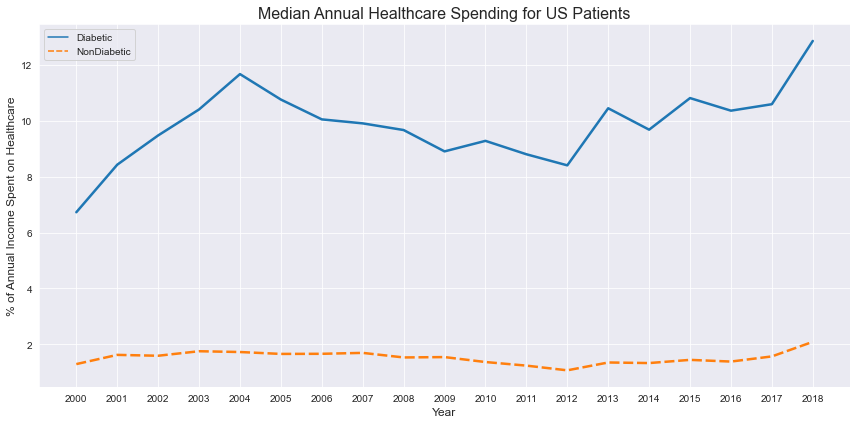

In [74]:
# displaying lineplots of annual % income spent on healthcare for both groups
plt.figure(figsize=(12, 6), tight_layout=True)

ax = sns.lineplot(data=df_perc*100, linewidth=2.5)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('% of Annual Income Spent on Healthcare', fontsize=12)
ax.set_title('Median Annual Healthcare Spending for US Patients', fontsize=16)
ax.set_xticks(list(range(2000, 2019)))

plt.show()

This plot has a similar look to the raw dollar expenditure plot, though it doesn't exhibit as noticeable of an upward trend.

To end this subsection, I calculate the increase in spending difference from 2000 to 2018.

In [75]:
# gap in % income spent on healthcare at year 2000
start_gap = df_perc.loc[2000,'Diabetic'] - df_perc.loc[2000,'NonDiabetic']
# gap in % income spent on healthcare at year 2018
end_gap = df_perc.loc[2018,'Diabetic'] - df_perc.loc[2018,'NonDiabetic']

# increase from 2000-2018
print('Median Annual Spending Gap Increase from 2000 to 2018:')
print(f'+{(end_gap - start_gap)*100}%')

Median Annual Spending Gap Increase from 2000 to 2018:
+5.341813864501953%


## Demographic Healthcare Spending Breakdown

### Race / Ethnicity

Recall from the column inspection & standardization section that the race/ethnicity column, *RACETHX*, has 3 categories: 0 (Other), 1 (Hispanic) & 2 (Black non-Hispanic).

Below, I construct box plots of annual healthcare expenditures for each available race/ethnicity group, separated by diabetic / non-diabetic.

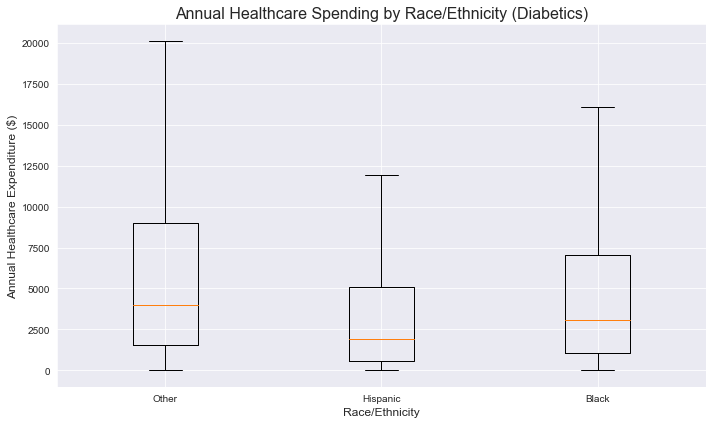

In [76]:
# initializing empty list, dataframe to fill out in FOR loop
series_list = []


# creating a series of healthcare spending data for each race/ethnicity group -- diabetics
for i in list(range(3)):
    series_list.append(df_y.loc[df_y['RACETHX'] == i]['HEALTH_EXP'])

# creating a dictionary to attach a label to each data collection in series_list
columns_dict = {'Other':series_list[0], 'Hispanic':series_list[1], 'Black':series_list[2]}

# plotting all boxplots on same figure
fig, ax = plt.subplots(figsize=(10,6))

ax.boxplot(columns_dict.values(), showfliers=False)
ax.set_xticklabels(columns_dict.keys())
ax.set_title('Annual Healthcare Spending by Race/Ethnicity (Diabetics)', fontsize=16)
ax.set_xlabel('Race/Ethnicity', fontsize=12)
ax.set_ylabel('Annual Healthcare Expenditure ($)', fontsize=12)

fig.tight_layout()

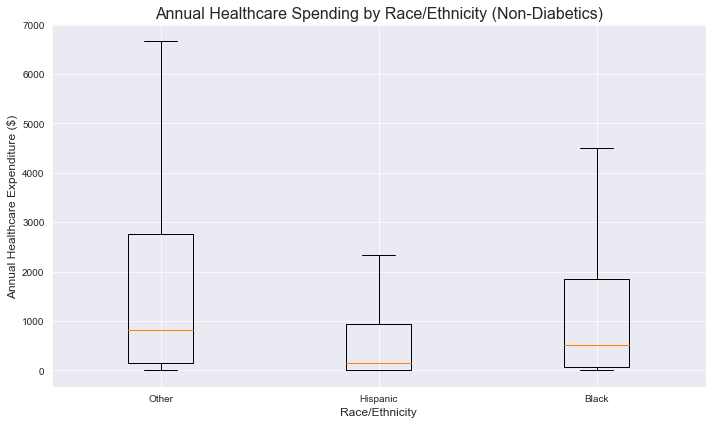

In [77]:
# initializing empty list, dataframe to fill out in FOR loop
series_list = []


# creating a series of healthcare spending data for each race/ethnicity group -- non-diabetics
for i in list(range(3)):
    series_list.append(df_n.loc[df_n['RACETHX'] == i]['HEALTH_EXP'])

# creating a dictionary to attach a label to each data collection in series_list
columns_dict = {'Other':series_list[0], 'Hispanic':series_list[1], 'Black':series_list[2]}

# plotting all boxplots on same figure
fig, ax = plt.subplots(figsize=(10,6))

ax.boxplot(columns_dict.values(), showfliers=False)
ax.set_xticklabels(columns_dict.keys())
ax.set_title('Annual Healthcare Spending by Race/Ethnicity (Non-Diabetics)', fontsize=16)
ax.set_xlabel('Race/Ethnicity', fontsize=12)
ax.set_ylabel('Annual Healthcare Expenditure ($)', fontsize=12)

fig.tight_layout()

### Age

This subsection begins with a statistical breakdown of the ages of all survey subject included at this point. Both the closeness of mean / median values & the histogram shape hint toward the ages having a normal distribution.

In [78]:
# statistical summary of age for ALL survey subjects
df['AGE'].describe()

count    261177.000000
mean         41.923661
std          12.356504
min          18.000000
25%          32.000000
50%          42.000000
75%          52.000000
max          65.000000
Name: AGE, dtype: float64

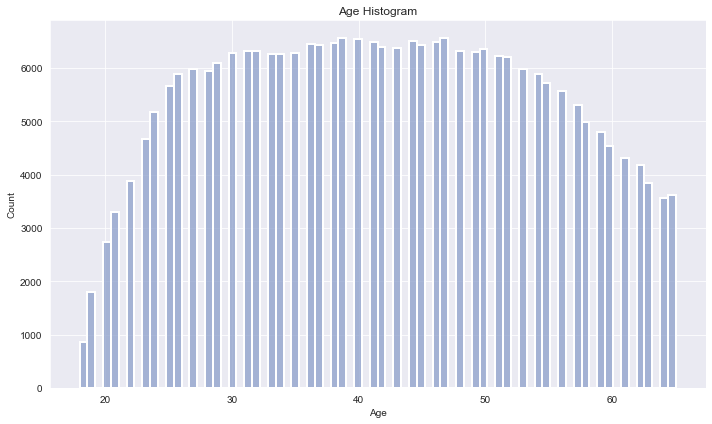

In [79]:
# plotting histogram of ages
plt.figure(figsize=(10,6), tight_layout=True)

ax = sns.histplot(data=df['AGE'], bins='auto', 
                  color=sns.color_palette('Set2')[2], linewidth=2)
ax.set_title('Age Histogram')
ax.set_xlabel('Age')
ax.set_ylabel('Count')

plt.show()

Next, I construct scatterplots of age against annual healthcare expenditures for both groups of interest.

In [80]:
# creating age bin borders & labels
bins=[18, 29, 38, 47, 56, 65]
labels=['18-28', '29-37', '38-46',
        '47-55', '56-65']

# binning AGE into 5 categories -- diabetics
df_y['AGECAT'] = pd.cut(df_y['AGE'], bins=bins, labels=labels, include_lowest=True)

# binning AGE into 5 categories -- non-diabetics
df_n['AGECAT'] = pd.cut(df_n['AGE'], bins=bins, labels=labels, include_lowest=True)

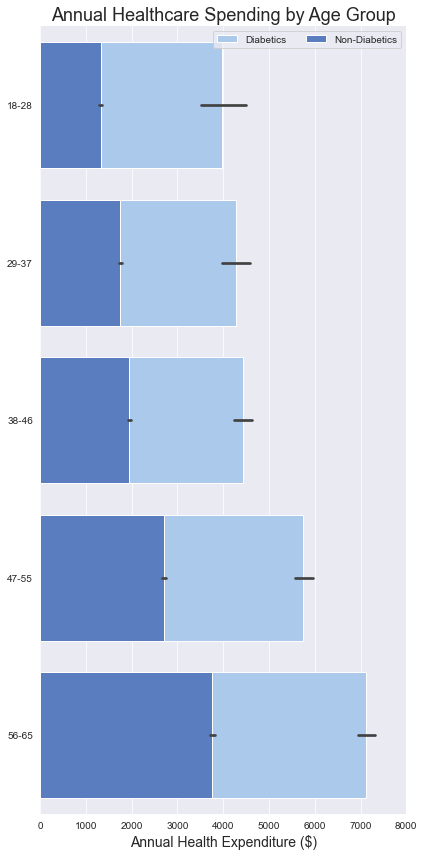

In [81]:
# initializing the matplotlib figure
fig, ax = plt.subplots(figsize=(6, 12))

# plotting the total crashes
sns.set_color_codes('pastel')
sns.barplot(x='HEALTH_EXP', y='AGECAT', data=df_y,
            label='Diabetics', color='b')

# Plot the crashes where alcohol was involved
sns.set_color_codes('muted')
sns.barplot(x='HEALTH_EXP', y='AGECAT', data=df_n,
            label='Non-Diabetics', color='b')

# Add a legend and informative axis label
ax.legend(ncol=2, loc='upper right', frameon=True)
ax.set(xlim=(0, 8000), ylabel='')
ax.set_xlabel('Annual Health Expenditure ($)', fontsize=14)
ax.set_title('Annual Healthcare Spending by Age Group', fontsize=18)
    
sns.despine(left=True, bottom=True)
fig.tight_layout()
# fig.savefig('AgeHealthcare.png')

### Income

This subsection begins with a statistical summary & visual depiction of the annual income values in the DataFrame. Recall that, in the Preprocessing section, a lower income threshold was set at 10,712 USD. Please refer to the aforementioned section for my reasoning behind the cutoff decision.

In [82]:
# statistical summary of income for ALL survey subjects
df['TTL_INC'].describe()

count    261177.000000
mean      41634.312386
std       33558.346012
min       10712.000000
25%       20000.000000
50%       31400.000000
75%       51000.000000
max      731653.000000
Name: TTL_INC, dtype: float64

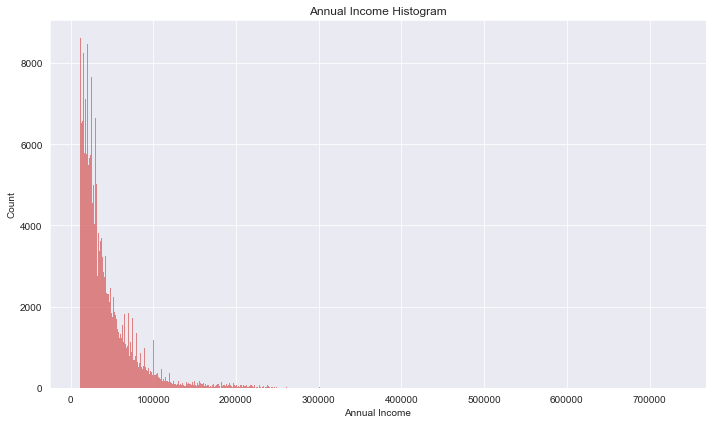

In [83]:
# plotting histogram of incomes
plt.figure(figsize=(10,6), tight_layout=True)

ax = sns.histplot(data=df['TTL_INC'], bins='auto', 
                  color='r', linewidth=0)
ax.set_title('Annual Income Histogram')
ax.set_xlabel('Annual Income')
ax.set_ylabel('Count')

plt.show()

The histogram above has an obvious right skew. 

In [84]:
# checking to see if data is evenly distributed across proposed income tiers
print(df.loc[(df['TTL_INC'] >= 10712) & (df['TTL_INC'] < 20000)].shape)
print(df.loc[(df['TTL_INC'] >= 20000) & (df['TTL_INC'] < 31200)].shape)
print(df.loc[(df['TTL_INC'] >= 31200) & (df['TTL_INC'] < 50308)].shape)
print(df.loc[(df['TTL_INC'] >= 50308) & (df['TTL_INC'] < 731653)].shape)

(63637, 14)
(65580, 14)
(65372, 14)
(66587, 14)


In [85]:
# creating income bin borders & labels
bins=[10712, 20000, 31200, 50308, 731653]
labels=['$10,712 - 20,000', '$20,000 - 31,200',
        '$31,200 - 50,308', '$50,308 - 731,653']

# binning TTL_INC into 5 categories -- diabetics
df_y['INCCAT'] = pd.cut(df_y['TTL_INC'], bins=bins, labels=labels, include_lowest=True)

# binning TTL_INC into 5 categories -- non-diabetics
df_n['INCCAT'] = pd.cut(df_n['TTL_INC'], bins=bins, labels=labels, include_lowest=True)

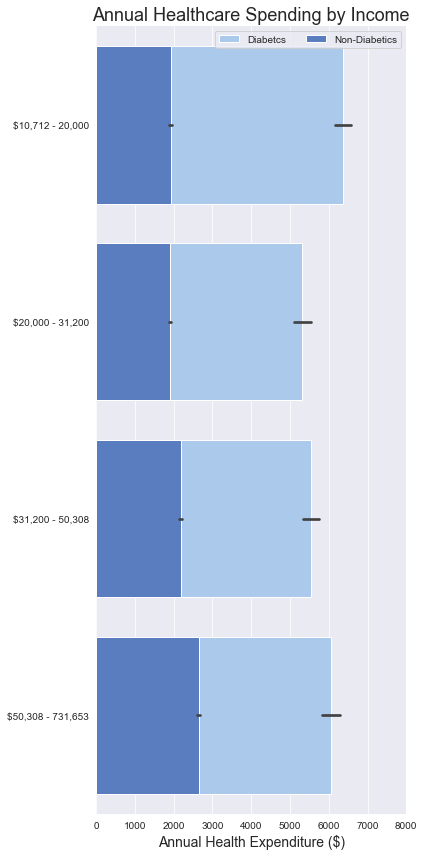

In [86]:
# initializing the matplotlib figure
fig, ax = plt.subplots(figsize=(6, 12))

# plotting the total crashes
sns.set_color_codes('pastel')
sns.barplot(x='HEALTH_EXP', y='INCCAT', data=df_y,
            label='Diabetcs', color='b')

# Plot the crashes where alcohol was involved
sns.set_color_codes('muted')
sns.barplot(x='HEALTH_EXP', y='INCCAT', data=df_n,
            label='Non-Diabetics', color='b')

# Add a legend and informative axis label
ax.legend(ncol=2, loc='upper right', frameon=True)
ax.set(xlim=(0, 8000), ylabel='')
ax.set_xlabel('Annual Health Expenditure ($)', fontsize=14)
ax.set_title('Annual Healthcare Spending by Income', fontsize=18)
    
sns.despine(left=True, bottom=True)
fig.tight_layout()

### Education Level

Recall from the column inspection & standardization section that the educational level column, *EDU_LVL*, has 8 categories: -1 (Inapplicable), 1 (No Degree), 2 (GED), 3 (High School Diploma), 4 (Bachelor's Degree), 5 (Master's Degree), 6 (Doctorate Degree) & 7 (Other Degree). 

Since categories -1 & 7 aren't particularly informative, I spend this portion focusing on categories 1-6. Below, I construct box plots of annual healthcare expenditures for the specified education levels, separated by diabetic / non-diabetic.

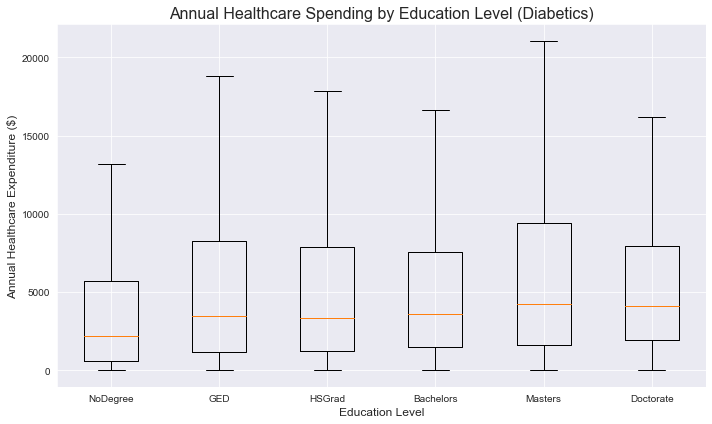

In [87]:
# initializing empty list, dataframe to fill out in FOR loop
series_list = []


# creating a series of healthcare spending data for education levels 1-6 -- diabetics
for i in list(range(1,7)):
    series_list.append(df_y.loc[df_y['EDU_LVL'] == i]['HEALTH_EXP'])

# creating a dictionary to attach a label to each data collection in series_list
columns_dict = {'NoDegree':series_list[0], 'GED':series_list[1], 'HSGrad':series_list[2],
                'Bachelors':series_list[3], 'Masters':series_list[4], 'Doctorate':series_list[5]}

# plotting all boxplots on same figure
fig, ax = plt.subplots(figsize=(10,6))

ax.boxplot(columns_dict.values(), showfliers=False)
ax.set_xticklabels(columns_dict.keys())
ax.set_title('Annual Healthcare Spending by Education Level (Diabetics)', fontsize=16)
ax.set_xlabel('Education Level', fontsize=12)
ax.set_ylabel('Annual Healthcare Expenditure ($)', fontsize=12)

fig.tight_layout()

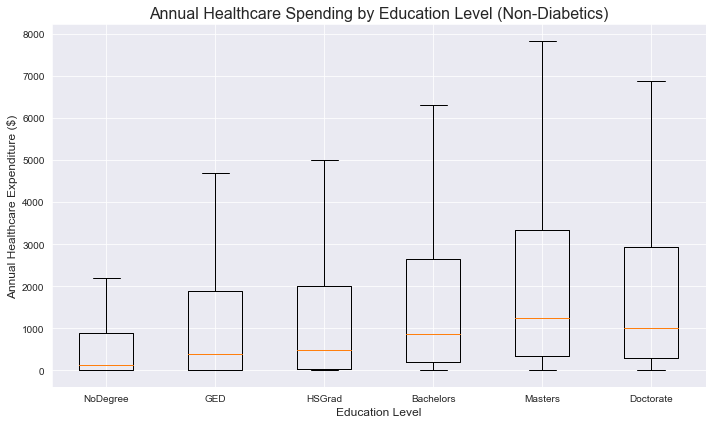

In [88]:
# initializing empty list, dataframe to fill out in FOR loop
series_list = []


# creating a series of healthcare spending data for education levels 1-6 -- non-diabetics
for i in list(range(1,7)):
    series_list.append(df_n.loc[df_n['EDU_LVL'] == i]['HEALTH_EXP'])

# creating a dictionary to attach a label to each data collection in series_list
columns_dict = {'NoDegree':series_list[0], 'GED':series_list[1], 'HSGrad':series_list[2],
                'Bachelors':series_list[3], 'Masters':series_list[4], 'Doctorate':series_list[5]}

# plotting all boxplots on same figure
fig, ax = plt.subplots(figsize=(10,6))

ax.boxplot(columns_dict.values(), showfliers=False)
ax.set_xticklabels(columns_dict.keys())
ax.set_title('Annual Healthcare Spending by Education Level (Non-Diabetics)', fontsize=16)
ax.set_xlabel('Education Level', fontsize=12)
ax.set_ylabel('Annual Healthcare Expenditure ($)', fontsize=12)

fig.tight_layout()

### US Geographic Region

Recall from the column inspection & standardization section that the US geographic region column, *REGION*, has 5 categories: -1 (Inapplicable), 1 (Northeast), 2 (Midwest), 3 (South), 4 (West). 

Category -1 isn't particulary informative, so I spend this portion focusing on categories 1-4. Below, I construct box plots of annual healthcare expenditures for each geographic region, separated by diabetic / non-diabetic.

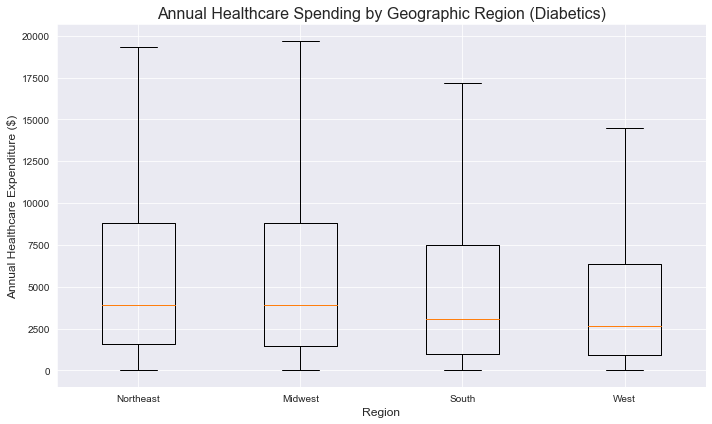

In [89]:
# initializing empty list, dataframe to fill out in FOR loop
series_list = []


# creating a series of healthcare spending data for each region -- diabetics
for i in list(range(1,5)):
    series_list.append(df_y.loc[df_y['REGION'] == i]['HEALTH_EXP'])

# creating a dictionary to attach a label to each data collection in series_list
columns_dict = {'Northeast':series_list[0], 'Midwest':series_list[1], 'South':series_list[2],
                'West':series_list[3]}

# plotting all boxplots on same figure
fig, ax = plt.subplots(figsize=(10,6))

ax.boxplot(columns_dict.values(), showfliers=False)
ax.set_xticklabels(columns_dict.keys())
ax.set_title('Annual Healthcare Spending by Geographic Region (Diabetics)', fontsize=16)
ax.set_xlabel('Region', fontsize=12)
ax.set_ylabel('Annual Healthcare Expenditure ($)', fontsize=12)

fig.tight_layout()

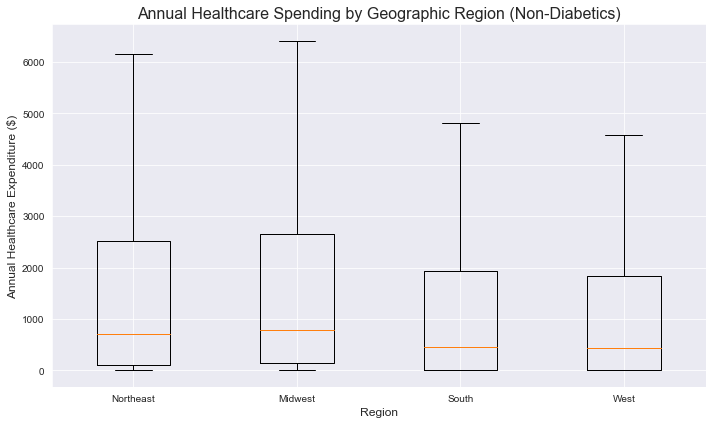

In [90]:
# initializing empty list, dataframe to fill out in FOR loop
series_list = []


# creating a series of healthcare spending data for each region -- non-diabetics
for i in list(range(1,5)):
    series_list.append(df_n.loc[df_n['REGION'] == i]['HEALTH_EXP'])

# creating a dictionary to attach a label to each data collection in series_list
columns_dict = {'Northeast':series_list[0], 'Midwest':series_list[1], 'South':series_list[2],
                'West':series_list[3]}

# plotting all boxplots on same figure
fig, ax = plt.subplots(figsize=(10,6))

ax.boxplot(columns_dict.values(), showfliers=False)
ax.set_xticklabels(columns_dict.keys())
ax.set_title('Annual Healthcare Spending by Geographic Region (Non-Diabetics)', fontsize=16)
ax.set_xlabel('Region', fontsize=12)
ax.set_ylabel('Annual Healthcare Expenditure ($)', fontsize=12)

fig.tight_layout()

## Target *HEALTH_EXP*: Inspecting Zero Values and Addressing Distribution

### Inspecting Zero Values

Recall the histograms on healthcare spending that began this EDA & Visualization session. In both plots, it is apparent that many entries in the target *HEALTH_EXP* column have a value of zero. 

<AxesSubplot:>

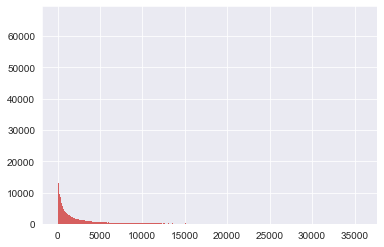

In [91]:
# displaying histogram of target HEALTH_EXP
df['HEALTH_EXP'].hist(bins='auto', color='r', lw=0)

In [92]:
# how many entries in dataset have target value of 0
print('% of total data with target value of 0:')
print(f'{(len(df.loc[df.HEALTH_EXP == 0].HEALTH_EXP) / len(df.HEALTH_EXP))*100}% \n')

# how many diabetics have target value of 0
print('% of data with target value of 0 (diabetics):')
print(f'{(len(df_y.loc[df_y.HEALTH_EXP == 0].HEALTH_EXP) / len(df_y.HEALTH_EXP))*100}% \n')

# how many non-diabetics have target value of 0
print('% of data with target value of 0 (non-diabetics):')
print(f'{(len(df_n.loc[df_n.HEALTH_EXP == 0].HEALTH_EXP) / len(df_n.HEALTH_EXP))*100}% \n')

% of total data with target value of 0:
21.50955099415339% 

% of data with target value of 0 (diabetics):
3.3110207984699978% 

% of data with target value of 0 (non-diabetics):
22.75522101086134% 



The prevalence of zeroes leads me to suspect that they may not be accurate reflections of healthcare spending -- for instance, 0 could be used as a placeholder healthcare expense value in the survey.

To ensure this is not the case, I construct a Random Forest classifier that predicts whether a given survey subject has a *HEALTH_EXP* value of 0 or not. If this classifier exhibits significantly better classification accuracy than a naive dummy classifier trained on the same data, I can be more confident that these zeroes are not accidental.

In [93]:
# creating a new column EXP_0 that classifies each entry into zero
# healthcare spending amount & non-zero healthcare spending amount
df['EXP_0'] = np.where(df['HEALTH_EXP']==0, 'Zero', 'Nonzero')

In [94]:
# confirming that the new column has the correct distribution of values
df['EXP_0'].value_counts(normalize=True)

Nonzero    0.784904
Zero       0.215096
Name: EXP_0, dtype: float64

In [95]:
# defining features & target
X = df.drop('EXP_0', axis=1)
y = df['EXP_0']

# performing train-test split on existing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=26)

In [96]:
# separating features into those that do & don't need one hot encoding
cont_or_binary = ['AGE', 'SEX', 'TTL_INC', 'INS_PRV',
                 'INS_TRI', 'INS_MCR', 'INS_MCD', 'DIABDX']
categoricals = ['REGION', 'RACETHX', 'EDU_LVL']

# instantiate OneHotEncoder() to deal with categoricals
enc = OneHotEncoder(handle_unknown='ignore')

# encoding categoricals & assembling features for classification -- training set
train_enc = pd.DataFrame(enc.fit_transform(X_train[categoricals]).toarray(),
                         columns=enc.get_feature_names(categoricals))
X_train = pd.concat([X_train[cont_or_binary].reset_index(drop=True),
                     train_enc.reset_index(drop=True)], axis=1)

# encoding categoricals & assembling features for classification -- test set
test_enc = pd.DataFrame(enc.transform(X_test[categoricals]).toarray(),
                         columns=enc.get_feature_names(categoricals))
X_test = pd.concat([X_test[cont_or_binary].reset_index(drop=True),
                    test_enc.reset_index(drop=True)], axis=1)

Now I have a binary class column as well as input/output data split into training/test sets for my classifier. As seen in the *value_counts()* display, though, there is a significant class imbalance issue. To counter this, I synthetically oversample from the minority "Zero" class using SMOTE.

In [97]:
# previous original class distribution
print(y_train.value_counts()) 

# fitting SMOTE to training data
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train) 

# previewing synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts()) 

Nonzero    153804
Zero        42078
Name: EXP_0, dtype: int64


Nonzero    153804
Zero       153804
Name: EXP_0, dtype: int64


Below is the baseline, naive classifier to which I can compare the random forest.

In [98]:
# instantiating, fitting uniform DummyClassifier
dummy_clf = DummyClassifier(strategy='uniform', random_state=26)
dummy_clf.fit(X_train_resampled, y_train_resampled)

DummyClassifier(random_state=26, strategy='uniform')

In [99]:
# creating different sets of predicted values to calculate training & test accuracies
y_hat_train = dummy_clf.predict(X_train_resampled)
y_hat_test = dummy_clf.predict(X_test)

# displaying dummy classification results
print(classification_report(y_test, y_hat_test))
print(f'Training Accuracy for Stratified Dummy Classifier: {(accuracy_score(y_train_resampled, y_hat_train)) * 100}%')
print(f'Testing Accuracy for Stratified Dummy Classifier: {(accuracy_score(y_test, y_hat_test)) * 100}%')

              precision    recall  f1-score   support

     Nonzero       0.78      0.50      0.61     51195
        Zero       0.22      0.50      0.30     14100

    accuracy                           0.50     65295
   macro avg       0.50      0.50      0.46     65295
weighted avg       0.66      0.50      0.54     65295

Training Accuracy for Stratified Dummy Classifier: 49.89239551637149%
Testing Accuracy for Stratified Dummy Classifier: 50.00995482043036%


And finally, the random forest classifier for *EXP_0*:

In [100]:
# instantiating RandomForestClassifier
forest = RandomForestClassifier(n_estimators=50, random_state=26)

# training random forest classifier
forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(n_estimators=50, random_state=26)

In [101]:
# creating different sets of predicted values to calculate training & test accuracies
y_hat_train = forest.predict(X_train_resampled)
y_hat_test = forest.predict(X_test)

# displaying classification results
print(classification_report(y_test, y_hat_test))
print(f'Training Accuracy for Random Forest Classifier: {(accuracy_score(y_train_resampled, y_hat_train)) * 100}%')
print(f'Testing Accuracy for Random Forest Classifier: {(accuracy_score(y_test, y_hat_test)) * 100}%')

              precision    recall  f1-score   support

     Nonzero       0.84      0.87      0.85     51195
        Zero       0.45      0.38      0.41     14100

    accuracy                           0.76     65295
   macro avg       0.64      0.62      0.63     65295
weighted avg       0.75      0.76      0.76     65295

Training Accuracy for Random Forest Classifier: 98.69606772255598%
Testing Accuracy for Random Forest Classifier: 76.41013860173061%


As seen in the difference between train & test accuracies (98.7% vs 76.3%), this classifier has a significant overfitting issue. Also, the performance metrics for the "Zero" category are poor. In particular, the "Zero" class' F1 score, a balanced combination of precision & recall, is less than half of the "Nonzero" class' F1 score.

Since there are performance issues with the classifier --  and especially since they have much to do with predicting the "Zero" class -- I elect to filter out any zero-spending *HEALTH_EXP* values before modeling.

In [102]:
# removing zero-spending values, updating df_y & df_n to reflect change
df = df.loc[df['HEALTH_EXP'] > 0]
df_y = df.loc[df['DIABDX'] == 1]
df_n = df.loc[df['DIABDX'] == 0]

### Addressing Target Distribution

<AxesSubplot:>

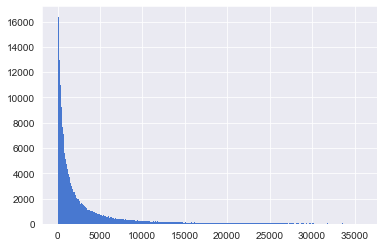

In [103]:
# displaying histogram of target values (annual healthcare spending)
df['HEALTH_EXP'].hist(bins='auto', color='b', lw=0)

Even with the removal of all zeroes, the target *HEATLH_EXP* is still very dense with the low values & heavily right skewed.

In order to construct regressors that can effectively predict values at both the low & high ends, with normally distributed error terms, a log transformation of this skewed dataset seems beneficial at this stage.

In [104]:
# log-transforming target for all three modeling datasets

# general
df['HEALTH_EXPLOG'] = np.log(df['HEALTH_EXP'])

# diabetics
df_y['HEALTH_EXPLOG'] = np.log(df_y['HEALTH_EXP'])

# non-diabetics
df_n['HEALTH_EXPLOG'] = np.log(df_n['HEALTH_EXP'])

<AxesSubplot:>

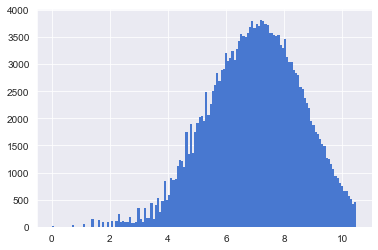

In [105]:
# displaying histogram of zero-less, log-transformed healthcare spending values
df['HEALTH_EXPLOG'].hist(bins='auto', color='b', lw=0)

****

# Feature Preparation

## Inspecting, Transforming Continuous Features

My models for this project only have two continous features: subject's age and annual income. Let's take another look at the distributions of both variables below.

<AxesSubplot:>

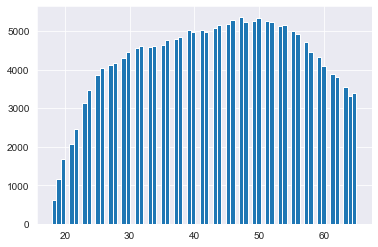

In [106]:
# displaying histogram of AGE feature to evaluate normality
df['AGE'].hist(bins='auto')

In [107]:
# statistical summary of AGE feature
df['AGE'].describe()

count    204999.000000
mean         43.193172
std          12.317650
min          18.000000
25%          33.000000
50%          44.000000
75%          53.000000
max          65.000000
Name: AGE, dtype: float64

Both the closeness of mean / median values & the histogram shape hint toward the subject ages following a normal distribution, or at least a distribution that does not need significant transformation. 

Next, a look at the annual income variable:

<AxesSubplot:>

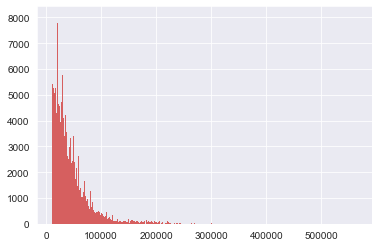

In [108]:
# displaying histogram of INCOME feature to evaluate normality
df['TTL_INC'].hist(bins='auto', color='r', lw=0)

This feature is heavily right skewed, much like the original target. In order to keep feature importance-based inferences interpretable, however, I elect to leave *TTL_INC* as is for now.

## Initial Train-Test Split

In [109]:
# creating a list of input features
features = ['AGE', 'SEX', 'TTL_INC', 'INS_PRV', 'INS_TRI',
            'INS_MCR', 'INS_MCD', 'DIABDX', 'REGION', 'RACETHX',
            'EDU_LVL']

# defining inputs, target & performing train-test split for all three modeling datasets

# general
X = df[features]
y = df['HEALTH_EXPLOG']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=26)

# diabetics
Xd = df_y[features].drop('DIABDX', axis=1)
yd = df_y['HEALTH_EXPLOG']
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, random_state=26)

# non-diabetics
Xnd = df_n[features].drop('DIABDX', axis=1)
ynd = df_n['HEALTH_EXPLOG']
Xnd_train, Xnd_test, ynd_train, ynd_test = train_test_split(Xnd, ynd, random_state=26)

## One Hot Encoding Categoricals, Assembling Features for Regression

Since this project is focused on demographic factors, a majority of the input features are categorical or binary. Of course, no processing is needed for the binary columns. 

The categoricals, however, need to go through one-hot encoding to create binary columns for separate categories. Once that is accomplished, the newly-created dummy columns are joined with the continuous & binary columns to assemble the final collection of features for modeling.

In [110]:
# updating continuous-or-binary feature list
cont_or_binary = ['AGE', 'SEX', 'TTL_INC', 'INS_PRV',
                 'INS_TRI', 'INS_MCR', 'INS_MCD', 'DIABDX']

# creating similar list for diabetic & non-diabetic subsets
cont_or_binary_dia = [x for x in cont_or_binary if x != 'DIABDX']

In [111]:
# encoding categoricals & assembling features for regression -- training set general
train_enc = pd.DataFrame(enc.fit_transform(X_train[categoricals]).toarray(),
                         columns=enc.get_feature_names(categoricals))

X_train = pd.concat([X_train[cont_or_binary].reset_index(drop=True),
                     train_enc.reset_index(drop=True)], axis=1)

# encoding categoricals & assembling features for regression -- test set general
test_enc = pd.DataFrame(enc.transform(X_test[categoricals]).toarray(),
                         columns=enc.get_feature_names(categoricals))

X_test = pd.concat([X_test[cont_or_binary].reset_index(drop=True),
                    test_enc.reset_index(drop=True)], axis=1)

In [112]:
# encoding categoricals & assembling features for regression -- training set diabetics
dtrain_enc = pd.DataFrame(enc.fit_transform(Xd_train[categoricals]).toarray(),
                         columns=enc.get_feature_names(categoricals))

Xd_train = pd.concat([Xd_train[cont_or_binary_dia].reset_index(drop=True),
                     dtrain_enc.reset_index(drop=True)], axis=1)

# encoding categoricals & assembling features for regression -- test set diabetics
dtest_enc = pd.DataFrame(enc.transform(Xd_test[categoricals]).toarray(),
                         columns=enc.get_feature_names(categoricals))

Xd_test = pd.concat([Xd_test[cont_or_binary_dia].reset_index(drop=True),
                    dtest_enc.reset_index(drop=True)], axis=1)

In [113]:
# encoding categoricals & assembling features for regression -- training set non-diabetics
ndtrain_enc = pd.DataFrame(enc.fit_transform(Xnd_train[categoricals]).toarray(),
                         columns=enc.get_feature_names(categoricals))

Xnd_train = pd.concat([Xnd_train[cont_or_binary_dia].reset_index(drop=True),
                     ndtrain_enc.reset_index(drop=True)], axis=1)

# encoding categoricals & assembling features for regression -- test set non-diabetics
ndtest_enc = pd.DataFrame(enc.transform(Xnd_test[categoricals]).toarray(),
                         columns=enc.get_feature_names(categoricals))

Xnd_test = pd.concat([Xnd_test[cont_or_binary_dia].reset_index(drop=True),
                    ndtest_enc.reset_index(drop=True)], axis=1)

In [114]:
# displaying assembled input features -- general
X_train.head()

,AGE,SEX,TTL_INC,INS_PRV,INS_TRI,INS_MCR,INS_MCD,DIABDX,REGION_-1,REGION_1,REGION_2,REGION_3,REGION_4,RACETHX_0,RACETHX_1,RACETHX_2,EDU_LVL_-1.0,EDU_LVL_1.0,EDU_LVL_2.0,EDU_LVL_3.0,EDU_LVL_4.0,EDU_LVL_5.0,EDU_LVL_6.0,EDU_LVL_7.0
0,45,0,63000.0,1,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,49,1,33550.0,1,1,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,48,1,30500.0,1,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,30,0,21500.0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,55,1,11704.0,1,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [115]:
# displaying assembled input features -- diabetics
Xd_train.head()

,AGE,SEX,TTL_INC,INS_PRV,INS_TRI,INS_MCR,INS_MCD,REGION_1,REGION_2,REGION_3,REGION_4,RACETHX_0,RACETHX_1,RACETHX_2,EDU_LVL_-1.0,EDU_LVL_1.0,EDU_LVL_2.0,EDU_LVL_3.0,EDU_LVL_4.0,EDU_LVL_5.0,EDU_LVL_6.0,EDU_LVL_7.0
0,49,0,50000.0,1,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,63,0,45816.0,1,0,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,62,0,14784.0,0,0,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,50,0,65000.0,1,0,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,53,1,27050.0,1,0,0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [116]:
# displaying assembled input features -- general
Xnd_train.head()

,AGE,SEX,TTL_INC,INS_PRV,INS_TRI,INS_MCR,INS_MCD,REGION_-1,REGION_1,REGION_2,REGION_3,REGION_4,RACETHX_0,RACETHX_1,RACETHX_2,EDU_LVL_-1.0,EDU_LVL_1.0,EDU_LVL_2.0,EDU_LVL_3.0,EDU_LVL_4.0,EDU_LVL_5.0,EDU_LVL_6.0,EDU_LVL_7.0
0,43,0,19600.0,1,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,26,0,13000.0,1,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,65,1,17435.0,0,0,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,32,1,11440.0,1,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,51,1,146595.0,1,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Modeling

In this section, models are constructed iteratively and each decision is made as a direct reaction to the model prior. Between models, destructive changes might be made to the dataset to improve modeling performance. Thus, I start by creating a backup of my main dataframe **df** so that I can restore its values if needed. 

In [117]:
# creating a copy of main dataset before any changes made in this section
df_backup = df

All subsections, aside from the very first baseline model, construct & tune 3 different models:

* General: Includes data on both diabetics & non-diabetics. This model's purpose is to let me know how important of a feature DIABDX is in determining (degree of) healthcare cost.

* Diabetics: Only includes data on diabetic survey subjects. This model's purpose is to let me know which demographic features are most important in determining (degree of) healthcare costs for diabetics.

* Non-Diabetics: Only includes data on non-diabetic survey subjects. This model's purpose is to let me know which demographic features are most important in determining (degree of) healthcare costs for non-diabetics.

## Baseline Decision Tree Regressor

I begin the modeling portion by constructing a baseline decision tree regressor. Since decision trees are generally weaker than their ensemble counterparts, I can use the performance metrics from this first model as a comparison point to guage whether my model performances are heading in a positive or negative direction.

In [118]:
# instantiating & fitting DecisionTreeRegressor()
model = DecisionTreeRegressor(random_state=26)
model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=26)

In [119]:
# making predictions on test data using trained model
y_trn_pred = model.predict(X_train)
y_pred = model.predict(X_test)

# printing performance metrics
print('Training R-square Value:', r2_score(y_train, y_trn_pred)) 
print('Test R-square Value:', r2_score(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Training R-square Value: 0.9716574448168065
Test R-square Value: -0.7098682873981763
Root Mean Squared Error: 2.0744763166551796


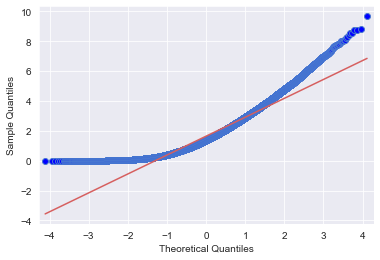

In [120]:
# determining how normally distributed error terms are 
fig = sm.qqplot(np.abs(y_test - y_pred),line='s')
plt.show()

As seen in the test & train R-squared values, this intial model has a severe overfitting problem. Not only is there a gap in magnitude for both metrics, but they also have opposite signs, showing that the trained model is incapable of handling any new data effectively. Additionally, the Q-Q plot of residuals reveals that the model is particularly bad at predicting even reasonably low (< -1st quantile) & high (> +1st quantile) *HEALTH_EXPLOG* values.

## Random Forests

Next, I expand from a single decision tree to the aggregate random forest. It is from here on, too, that I construct three models for every algorithm used: general population, diabetics, non-diabetics. 

For all sections going forward, I will hold my commentary until modeling is done for each group, unless one of the models performs entirely differently than the others.

### General

In [121]:
# instantiating RandomForestRegressor()
forest = RandomForestRegressor(n_estimators=50, random_state=26)

# running forest through cross_validate to obtain performance metrics
scores = cross_validate(forest, X_train, y_train, cv=3,
                        scoring=('r2', 'neg_root_mean_squared_error'),
                        return_train_score=True)

In [122]:
# training R-squared
print('Training R-squared Vals:')
print(scores['train_r2'])
print('Mean Training R-squared:')
print(scores['train_r2'].mean(), '\n')

# test R-squared
print('Test R-squared Vals:')
print(scores['test_r2'])
print('Mean Test R-squared:')
print(scores['test_r2'].mean(), '\n')

# root mean square error
print('RMSE Vals:')
print(scores['test_neg_root_mean_squared_error'])
print('Mean RMSE:')
print(scores['test_neg_root_mean_squared_error'].mean())

Training R-squared Vals:
[0.84660159 0.8469022  0.84686668]
Mean Training R-squared:
0.8467901570449291 

Test R-squared Vals:
[0.02750939 0.03561705 0.02272704]
Mean Test R-squared:
0.02861782511372916 

RMSE Vals:
[-1.57145452 -1.55857805 -1.56296754]
Mean RMSE:
-1.5643333663167995


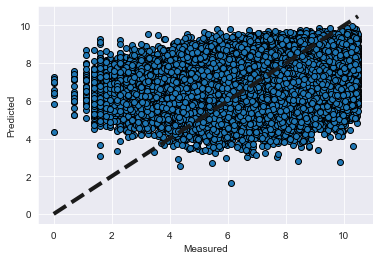

In [123]:
# making predictions with random forest
predicted = cross_val_predict(forest, X_train, y_train, cv=3)

# displaying plot of measured target values vs. predicted target values
fig, ax = plt.subplots()

ax.scatter(y_train, predicted, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

plt.show()

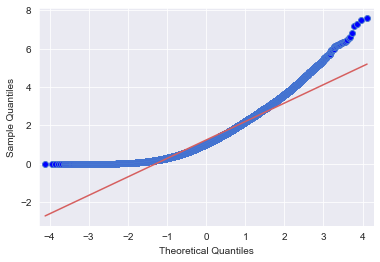

In [124]:
# fitting model to training data
forest.fit(X_train, y_train)

# making predictions on test data 
y_pred = forest.predict(X_test)

# determining how normally distributed error terms are 
fig = sm.qqplot(np.abs(y_test - y_pred),line='s')
plt.show()

### Diabetics

In [125]:
# instantiating RandomForestRegressor()
forest = RandomForestRegressor(n_estimators=50, random_state=26)

# running forest through cross_validate to obtain performance metrics
scores = cross_validate(forest, Xd_train, yd_train, cv=3,
                        scoring=('r2', 'neg_root_mean_squared_error'),
                        return_train_score=True)

In [126]:
# training R-squared
print('Training R-squared Vals:')
print(scores['train_r2'])
print('Mean Training R-squared:')
print(scores['train_r2'].mean(), '\n')

# test R-squared
print('Test R-squared Vals:')
print(scores['test_r2'])
print('Mean Test R-squared:')
print(scores['test_r2'].mean(), '\n')

# root mean square error
print('RMSE Vals:')
print(scores['test_neg_root_mean_squared_error'])
print('Mean RMSE:')
print(scores['test_neg_root_mean_squared_error'].mean())

Training R-squared Vals:
[0.8636504  0.86205236 0.85875413]
Mean Training R-squared:
0.8614856325306554 

Test R-squared Vals:
[0.04168428 0.01722342 0.06131198]
Mean Test R-squared:
0.04007322354404689 

RMSE Vals:
[-1.39039374 -1.39513067 -1.36276018]
Mean RMSE:
-1.382761529382976


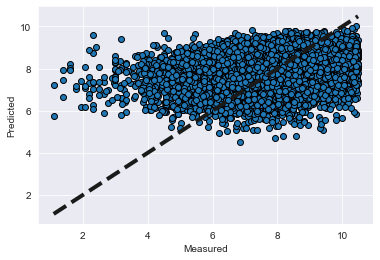

In [127]:
# making predictions with random forest
predicted = cross_val_predict(forest, Xd_train, yd_train, cv=3)

# displaying plot of measured target values vs. predicted target values
fig, ax = plt.subplots()

ax.scatter(yd_train, predicted, edgecolors=(0, 0, 0))
ax.plot([yd_train.min(), yd_train.max()], [yd_train.min(), yd_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

plt.show()

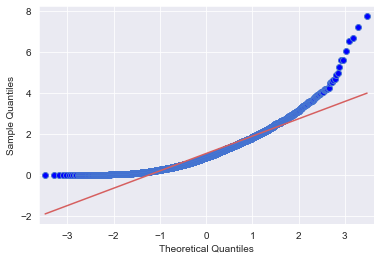

In [128]:
# fitting model to training data
forest.fit(Xd_train, yd_train)

# making predictions on test data 
yd_pred = forest.predict(Xd_test)

# determining how normally distributed error terms are 
fig = sm.qqplot(np.abs(yd_test - yd_pred),line='s')
plt.show()

### Non-Diabetics

In [129]:
# instantiating RandomForestRegressor()
forest = RandomForestRegressor(n_estimators=50, random_state=26)

# running forest through cross_validate to obtain performance metrics
scores = cross_validate(forest, Xnd_train, ynd_train, cv=3,
                        scoring=('r2', 'neg_root_mean_squared_error'),
                        return_train_score=True)

In [130]:
# training R-squared
print('Training R-squared Vals:')
print(scores['train_r2'])
print('Mean Training R-squared:')
print(scores['train_r2'].mean(), '\n')

# test R-squared
print('Test R-squared Vals:')
print(scores['test_r2'])
print('Mean Test R-squared:')
print(scores['test_r2'].mean(), '\n')

# root mean square error
print('RMSE Vals:')
print(scores['test_neg_root_mean_squared_error'])
print('Mean RMSE:')
print(scores['test_neg_root_mean_squared_error'].mean())

Training R-squared Vals:
[0.83999916 0.83920497 0.83920793]
Mean Training R-squared:
0.8394706863311892 

Test R-squared Vals:
[-0.0157552  -0.01639484 -0.00934696]
Mean Test R-squared:
-0.013832332317962917 

RMSE Vals:
[-1.57825215 -1.585722   -1.58630637]
Mean RMSE:
-1.5834268412517567


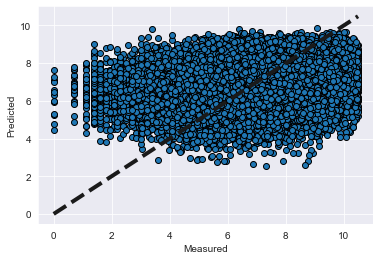

In [131]:
# making predictions with random forest
predicted = cross_val_predict(forest, Xnd_train, ynd_train, cv=3)

# displaying plot of measured target values vs. predicted target values
fig, ax = plt.subplots()

ax.scatter(ynd_train, predicted, edgecolors=(0, 0, 0))
ax.plot([ynd_train.min(), ynd_train.max()], [ynd_train.min(), ynd_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

plt.show()

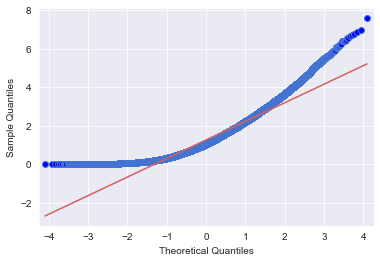

In [132]:
# fitting model to training data
forest.fit(Xnd_train, ynd_train)

# making predictions on test data 
ynd_pred = forest.predict(Xnd_test)

# determining how normally distributed error terms are 
fig = sm.qqplot(np.abs(ynd_test - ynd_pred),line='s')
plt.show()

Compared to the baseline decision tree, these forests consistently performed better. 

The gap between train & test R-squared's (+0.97 to -0.71 for DT; ~+0.85 to ~+0.02 on avg for RF) is significantly improved, but the overfitting is still massive. The lower RMSE magnitude (2.07 for DT; ~1.5 on avg for RF) is a good sign as well. But since the target is log-transformed, an RMSE that falls at least below 1 in magnitude would be preferable. Finally, the Q-Q plot hints at similar issues with predicting low & high values.

Since this algorithm improved performance metrics across the board, let's keep going with ensemble regressors to see if any of them can continue this improvement to the point of an acceptable model. Next, I try out an XGBoost regressor for each group of interest.

## XGBoost Regressor

### General

In [133]:
# instantiating XGBRegressor()
xgb = XGBRegressor(n_estimators=50, random_state=26)

# running xgboost through cross_validate to obtain performance metrics
scores = cross_validate(xgb, X_train, y_train, cv=3,
                        scoring=('r2', 'neg_root_mean_squared_error'),
                        return_train_score=True)

In [134]:
# training R-squared
print('Training R-squared Vals:')
print(scores['train_r2'])
print('Mean Training R-squared:')
print(scores['train_r2'].mean(), '\n')

# test R-squared
print('Test R-squared Vals:')
print(scores['test_r2'])
print('Mean Test R-squared:')
print(scores['test_r2'].mean(), '\n')

# root mean square error
print('RMSE Vals:')
print(scores['test_neg_root_mean_squared_error'])
print('Mean RMSE:')
print(scores['test_neg_root_mean_squared_error'].mean())

Training R-squared Vals:
[0.20250271 0.20333325 0.20720107]
Mean Training R-squared:
0.20434567705148898 

Test R-squared Vals:
[0.16321925 0.16476524 0.15501371]
Mean Test R-squared:
0.16099940030159107 

RMSE Vals:
[-1.45768924 -1.45046773 -1.45333873]
Mean RMSE:
-1.4538319004224363


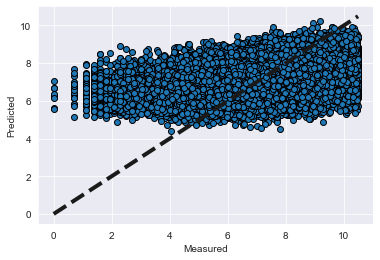

In [135]:
# making predictions with xgboost
predicted = cross_val_predict(xgb, X_train, y_train, cv=3)

# displaying plot of measured target values vs. predicted target values
fig, ax = plt.subplots()

ax.scatter(y_train, predicted, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

plt.show()

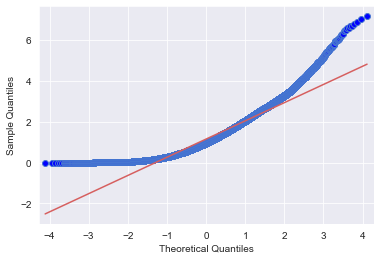

In [136]:
# fitting model to training data
xgb.fit(X_train, y_train)

# making predictions on test data 
y_pred = xgb.predict(X_test)

# determining how normally distributed error terms are 
fig = sm.qqplot(np.abs(y_test - y_pred),line='s')
plt.show()

### Diabetics

In [137]:
# instantiating XGBRegressor()
xgb = XGBRegressor(n_estimators=50, random_state=26)

# running xgboost through cross_validate to obtain performance metrics
scores = cross_validate(xgb, Xd_train, yd_train, cv=3,
                        scoring=('r2', 'neg_root_mean_squared_error'),
                        return_train_score=True)

In [138]:
# training R-squared
print('Training R-squared Vals:')
print(scores['train_r2'])
print('Mean Training R-squared:')
print(scores['train_r2'].mean(), '\n')

# test R-squared
print('Test R-squared Vals:')
print(scores['test_r2'])
print('Mean Test R-squared:')
print(scores['test_r2'].mean(), '\n')

# root mean square error
print('RMSE Vals:')
print(scores['test_neg_root_mean_squared_error'])
print('Mean RMSE:')
print(scores['test_neg_root_mean_squared_error'].mean())

Training R-squared Vals:
[0.41087015 0.42356732 0.4055425 ]
Mean Training R-squared:
0.41332665718442857 

Test R-squared Vals:
[0.0965095  0.07595971 0.12709248]
Mean Test R-squared:
0.09985389700011078 

RMSE Vals:
[-1.35003582 -1.35279796 -1.31414387]
Mean RMSE:
-1.3389925506076865


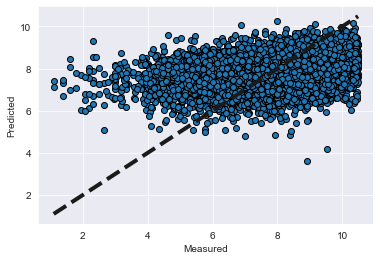

In [139]:
# making predictions with xgboost
predicted = cross_val_predict(xgb, Xd_train, yd_train, cv=3)

# displaying plot of measured target values vs. predicted target values
fig, ax = plt.subplots()

ax.scatter(yd_train, predicted, edgecolors=(0, 0, 0))
ax.plot([yd_train.min(), yd_train.max()], [yd_train.min(), yd_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

plt.show()

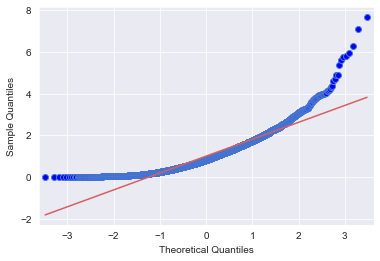

In [140]:
# fitting model to training data
xgb.fit(Xd_train, yd_train)

# making predictions on test data 
yd_pred = xgb.predict(Xd_test)

# determining how normally distributed error terms are 
fig = sm.qqplot(np.abs(yd_test - yd_pred),line='s')
plt.show()

### Non-Diabetics

In [141]:
# instantiating XGBRegressor()
xgb = XGBRegressor(n_estimators=50, random_state=26)

# running xgboost through cross_validate to obtain performance metrics
scores = cross_validate(xgb, Xnd_train, ynd_train, cv=3,
                        scoring=('r2', 'neg_root_mean_squared_error'),
                        return_train_score=True)

In [142]:
# training R-squared
print('Training R-squared Vals:')
print(scores['train_r2'])
print('Mean Training R-squared:')
print(scores['train_r2'].mean(), '\n')

# test R-squared
print('Test R-squared Vals:')
print(scores['test_r2'])
print('Mean Test R-squared:')
print(scores['test_r2'].mean(), '\n')

# root mean square error
print('RMSE Vals:')
print(scores['test_neg_root_mean_squared_error'])
print('Mean RMSE:')
print(scores['test_neg_root_mean_squared_error'].mean())

Training R-squared Vals:
[0.17496446 0.17418299 0.17412832]
Mean Training R-squared:
0.17442525727152614 

Test R-squared Vals:
[0.12616848 0.12730735 0.13065835]
Mean Test R-squared:
0.12804472696145222 

RMSE Vals:
[-1.4638471  -1.46935416 -1.47218393]
Mean RMSE:
-1.4684617273407914


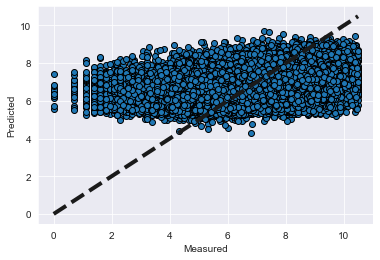

In [143]:
# making predictions with xgboost
predicted = cross_val_predict(xgb, Xnd_train, ynd_train, cv=3)

# displaying plot of measured target values vs. predicted target values
fig, ax = plt.subplots()

ax.scatter(ynd_train, predicted, edgecolors=(0, 0, 0))
ax.plot([ynd_train.min(), ynd_train.max()], [ynd_train.min(), ynd_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

plt.show()

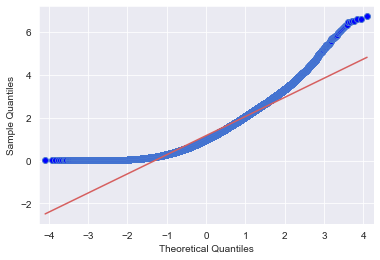

In [144]:
# fitting model to training data
xgb.fit(Xnd_train, ynd_train)

# making predictions on test data 
ynd_pred = xgb.predict(Xnd_test)

# determining how normally distributed error terms are 
fig = sm.qqplot(np.abs(ynd_test - ynd_pred),line='s')
plt.show()

The XGBoost regressors certainly show an improvement in overfitting, as evidenced by the train-test R-squared gap (~+0.85 to ~+0.02 on avg for RF; ~+0.26 to ~+0.13 on avg for XG). Overall, though, the results are largely the same -- underwhelming test R-squared, RMSE with a magnitude around 1.5, and trouble predicting *HEALTH_EXPLOG* values at the lower & higher ends of the dataset.

Worth noting here, too, is that the performance metrics for the diabetic-focused regressor are slightly worse than those for its counterparts. This could be something to monitor throughout subsequent modeling.

I decide to try one more ensemble regressor -- Extra Trees -- to see if it's possible to improve the test R-squared in any meaningful way through this modeling approach. 

## Extra Trees Regressor

### General

In [145]:
# instantiating ExtraTreesRegressor()
xtrgr = ExtraTreesRegressor(n_estimators=50, random_state=26)

# running extra trees through cross_validate to obtain performance metrics
scores = cross_validate(xtrgr, X_train, y_train, cv=3,
                        scoring=('r2', 'neg_root_mean_squared_error'),
                        return_train_score=True)

In [146]:
# training R-squared
print('Training R-squared Vals:')
print(scores['train_r2'])
print('Mean Training R-squared:')
print(scores['train_r2'].mean(), '\n')

# test R-squared
print('Test R-squared Vals:')
print(scores['test_r2'])
print('Mean Test R-squared:')
print(scores['test_r2'].mean(), '\n')

# root mean square error
print('RMSE Vals:')
print(scores['test_neg_root_mean_squared_error'])
print('Mean RMSE:')
print(scores['test_neg_root_mean_squared_error'].mean())

Training R-squared Vals:
[0.98004023 0.98033129 0.979187  ]
Mean Training R-squared:
0.9798528405449719 

Test R-squared Vals:
[-0.22712321 -0.229838   -0.23475347]
Mean Test R-squared:
-0.23057155807584273 

RMSE Vals:
[-1.7652377  -1.7600611  -1.75683972]
Mean RMSE:
-1.760712841057142


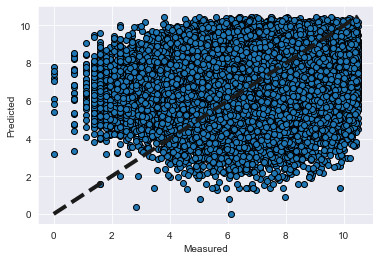

In [147]:
# making predictions with extra trees
predicted = cross_val_predict(xtrgr, X_train, y_train, cv=3)

# displaying plot of measured target values vs. predicted target values
fig, ax = plt.subplots()

ax.scatter(y_train, predicted, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

plt.show()

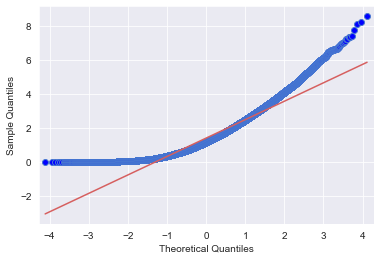

In [148]:
# fitting model to training data
xtrgr.fit(X_train, y_train)

# making predictions on test data 
y_pred = xtrgr.predict(X_test)

# determining how normally distributed error terms are 
fig = sm.qqplot(np.abs(y_test - y_pred),line='s')
plt.show()

### Diabetics

In [149]:
# instantiating ExtraTreesRegressor()
xtrgr = ExtraTreesRegressor(n_estimators=50, random_state=26)

# running extra trees through cross_validate to obtain performance metrics
scores = cross_validate(xtrgr, Xd_train, yd_train, cv=3,
                        scoring=('r2', 'neg_root_mean_squared_error'),
                        return_train_score=True)

In [150]:
# training R-squared
print('Training R-squared Vals:')
print(scores['train_r2'])
print('Mean Training R-squared:')
print(scores['train_r2'].mean(), '\n')

# test R-squared
print('Test R-squared Vals:')
print(scores['test_r2'])
print('Mean Test R-squared:')
print(scores['test_r2'].mean(), '\n')

# root mean square error
print('RMSE Vals:')
print(scores['test_neg_root_mean_squared_error'])
print('Mean RMSE:')
print(scores['test_neg_root_mean_squared_error'].mean())

Training R-squared Vals:
[0.99743118 0.99788719 0.99690412]
Mean Training R-squared:
0.9974074974523587 

Test R-squared Vals:
[-0.15260027 -0.18223706 -0.12500622]
Mean Test R-squared:
-0.1532811858373754 

RMSE Vals:
[-1.52483502 -1.53017031 -1.49188813]
Mean RMSE:
-1.5156311513041594


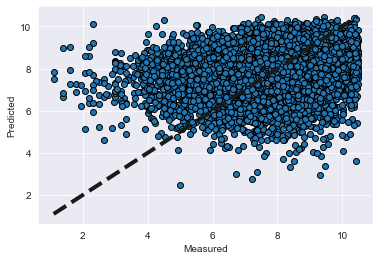

In [151]:
# making predictions with extra trees
predicted = cross_val_predict(xtrgr, Xd_train, yd_train, cv=3)

# displaying plot of measured target values vs. predicted target values
fig, ax = plt.subplots()

ax.scatter(yd_train, predicted, edgecolors=(0, 0, 0))
ax.plot([yd_train.min(), yd_train.max()], [yd_train.min(), yd_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

plt.show()

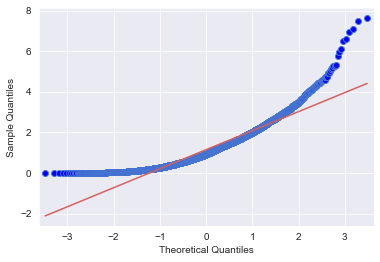

In [152]:
# fitting model to training data
xtrgr.fit(Xd_train, yd_train)

# making predictions on test data 
yd_pred = xtrgr.predict(Xd_test)

# determining how normally distributed error terms are 
fig = sm.qqplot(np.abs(yd_test - yd_pred),line='s')
plt.show()

### Non-Diabetics

In [153]:
# instantiating ExtraTreesRegressor()
xtrgr = ExtraTreesRegressor(n_estimators=50, random_state=26)

# running extra trees through cross_validate to obtain performance metrics
scores = cross_validate(xtrgr, Xnd_train, ynd_train, cv=3,
                        scoring=('r2', 'neg_root_mean_squared_error'),
                        return_train_score=True)

In [154]:
# training R-squared
print('Training R-squared Vals:')
print(scores['train_r2'])
print('Mean Training R-squared:')
print(scores['train_r2'].mean(), '\n')

# test R-squared
print('Test R-squared Vals:')
print(scores['test_r2'])
print('Mean Test R-squared:')
print(scores['test_r2'].mean(), '\n')

# root mean square error
print('RMSE Vals:')
print(scores['test_neg_root_mean_squared_error'])
print('Mean RMSE:')
print(scores['test_neg_root_mean_squared_error'].mean())

Training R-squared Vals:
[0.97879699 0.97735933 0.97781751]
Mean Training R-squared:
0.9779912751249347 

Test R-squared Vals:
[-0.29180053 -0.28988386 -0.27873082]
Mean Test R-squared:
-0.28680506701610226 

RMSE Vals:
[-1.77983438 -1.78636882 -1.78548578]
Mean RMSE:
-1.7838963262966276


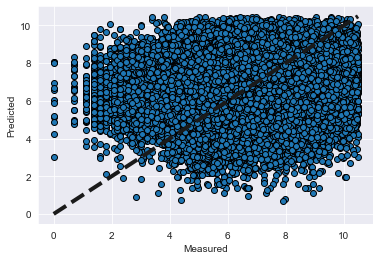

In [155]:
# making predictions with extra trees
predicted = cross_val_predict(xtrgr, Xnd_train, ynd_train, cv=3)

# displaying plot of measured target values vs. predicted target values
fig, ax = plt.subplots()

ax.scatter(ynd_train, predicted, edgecolors=(0, 0, 0))
ax.plot([ynd_train.min(), ynd_train.max()], [ynd_train.min(), ynd_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

plt.show()

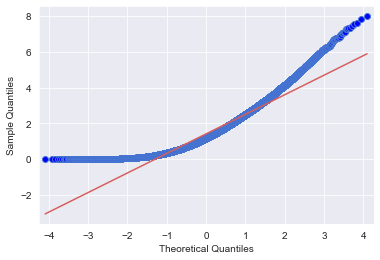

In [156]:
# fitting model to training data
xtrgr.fit(Xnd_train, ynd_train)

# making predictions on test data 
ynd_pred = xtrgr.predict(Xnd_test)

# determining how normally distributed error terms are 
fig = sm.qqplot(np.abs(ynd_test - ynd_pred),line='s')
plt.show()

Though this iteration could be considered a step back in a few ways, from the slightly worse RMSE values to the train-test R-squared's having opposite signs, I also notice that the magnitude of test R-squared's is higher across the board. Due to this fact, I opt to stick with this ensemble method for a few more iterations to see how much its performance can improve.

Before running extra trees once more, I make an adjustment on target values.

## Making Adjustments: Filtering Values

One commonality between every single model run prior is that their predictive power worsens as they move toward the margins of *HEALTH_EXPLOG* values. This is evidenced by the Q-Q plots for each model. 

While this phenomenon might be acceptable if the predictions only got worse at extremes (like the +/-3rd quantile & beyond), each model only indicates dependable results between the -1st & +1st quantiles. 

One potential fix here could be to narrow the scope of modeling to more typical healthcare spending values while keeping most data points. In other words, I'd rather construct a regressor that successfully makes predictions for a majority of my population of interest than one that unsuccessfully makes predictions for the entire group.

This is not to guarantee that such a measure will produce results, though. But with the Q-Q plots as tailed as they are, and the target *HEALTH_EXPLOG* following a fairly normal distribution as is, this currently seems like the best strategy. 

In [157]:
# statistical breakdown of HEALTH_EXP column
df['HEALTH_EXP'].describe()

count    204999.000000
mean       3062.226362
std        5003.967390
min           1.000000
25%         362.000000
50%        1137.000000
75%        3349.000000
max       35868.000000
Name: HEALTH_EXP, dtype: float64

In [158]:
# variables for 10th & 90th percentile values
tenth = df['HEALTH_EXP'].quantile(0.1)
ninetieth = df['HEALTH_EXP'].quantile(0.9)

# displaying values at 10th & 90th percentile 
print(f'10th percentile: {tenth}')
print(f'90th percentile: {ninetieth}')

10th percentile: 132.0
90th percentile: 8228.0


In [159]:
# filtering dataset, updating diabetic & non-dibetic subsets
df = df.loc[(df['HEALTH_EXP'] >= tenth) & (df['HEALTH_EXP'] <= ninetieth)]
df_y = df.loc[df['DIABDX'] == 1]
df_n = df.loc[df['DIABDX'] == 0]

I ultimately elect to keep all data points between the 10th & 90th percentile, dropping the outermost 20% of entries. After filtering, I reperform the train-test split across all groups of interest.

In [160]:
# assigning features/target, performing train-test split -- general 
X = df[features]
y = df['HEALTH_EXPLOG']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=26)

# encoding categoricals & assembling features for regression -- training set general
train_enc = pd.DataFrame(enc.fit_transform(X_train[categoricals]).toarray(),
                         columns=enc.get_feature_names(categoricals))

X_train = pd.concat([X_train[cont_or_binary].reset_index(drop=True),
                     train_enc.reset_index(drop=True)], axis=1)

# encoding categoricals & assembling features for regression -- test set general
test_enc = pd.DataFrame(enc.transform(X_test[categoricals]).toarray(),
                         columns=enc.get_feature_names(categoricals))

X_test = pd.concat([X_test[cont_or_binary].reset_index(drop=True),
                    test_enc.reset_index(drop=True)], axis=1)

In [161]:
# assigning features/target, performing train-test split -- diabetics 
Xd = df_y[features].drop('DIABDX', axis=1)
yd = df_y['HEALTH_EXPLOG']
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, random_state=26)

# encoding categoricals & assembling features for regression -- training set diabetics
dtrain_enc = pd.DataFrame(enc.fit_transform(Xd_train[categoricals]).toarray(),
                         columns=enc.get_feature_names(categoricals))

Xd_train = pd.concat([Xd_train[cont_or_binary_dia].reset_index(drop=True),
                     dtrain_enc.reset_index(drop=True)], axis=1)

# encoding categoricals & assembling features for regression -- test set diabetics
dtest_enc = pd.DataFrame(enc.transform(Xd_test[categoricals]).toarray(),
                         columns=enc.get_feature_names(categoricals))

Xd_test = pd.concat([Xd_test[cont_or_binary_dia].reset_index(drop=True),
                    dtest_enc.reset_index(drop=True)], axis=1)

In [162]:
# assigning features/target, performing train-test split -- non-diabetics 
Xnd = df_n[features].drop('DIABDX', axis=1)
ynd = df_n['HEALTH_EXPLOG']
Xnd_train, Xnd_test, ynd_train, ynd_test = train_test_split(Xnd, ynd, random_state=26)

# encoding categoricals & assembling features for regression -- training set non-diabetics
ndtrain_enc = pd.DataFrame(enc.fit_transform(Xnd_train[categoricals]).toarray(),
                         columns=enc.get_feature_names(categoricals))

Xnd_train = pd.concat([Xnd_train[cont_or_binary_dia].reset_index(drop=True),
                     ndtrain_enc.reset_index(drop=True)], axis=1)

# encoding categoricals & assembling features for regression -- test set non-diabetics
ndtest_enc = pd.DataFrame(enc.transform(Xnd_test[categoricals]).toarray(),
                         columns=enc.get_feature_names(categoricals))

Xnd_test = pd.concat([Xnd_test[cont_or_binary_dia].reset_index(drop=True),
                    ndtest_enc.reset_index(drop=True)], axis=1)

## Extra Trees Regressor

Now that the outermost expenditure values (and therefore, the outermost *HEALTH_EXPLOG* values) have been dropped, let's see if the extra trees regressor does a better predictive job across the board.

### General

In [163]:
# instantiating ExtraTreesRegressor()
xtrgr = ExtraTreesRegressor(n_estimators=50, random_state=26)

# running extra trees through cross_validate to obtain performance metrics
scores = cross_validate(xtrgr, X_train, y_train, cv=3,
                        scoring=('r2', 'neg_root_mean_squared_error'),
                        return_train_score=True)

In [164]:
# training R-squared
print('Training R-squared Vals:')
print(scores['train_r2'])
print('Mean Training R-squared:')
print(scores['train_r2'].mean(), '\n')

# test R-squared
print('Test R-squared Vals:')
print(scores['test_r2'])
print('Mean Test R-squared:')
print(scores['test_r2'].mean(), '\n')

# root mean square error
print('RMSE Vals:')
print(scores['test_neg_root_mean_squared_error'])
print('Mean RMSE:')
print(scores['test_neg_root_mean_squared_error'].mean())

Training R-squared Vals:
[0.98286812 0.98228839 0.98225757]
Mean Training R-squared:
0.9824713615861093 

Test R-squared Vals:
[-0.30580979 -0.31828345 -0.30777156]
Mean Test R-squared:
-0.3106216025155908 

RMSE Vals:
[-1.23869305 -1.23739785 -1.23880595]
Mean RMSE:
-1.2382989516019782


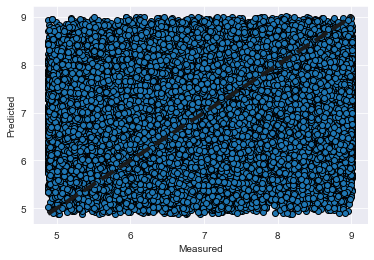

In [165]:
# making predictions with extra trees
predicted = cross_val_predict(xtrgr, X_train, y_train, cv=3)

# displaying plot of measured target values vs. predicted target values
fig, ax = plt.subplots()

ax.scatter(y_train, predicted, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

plt.show()

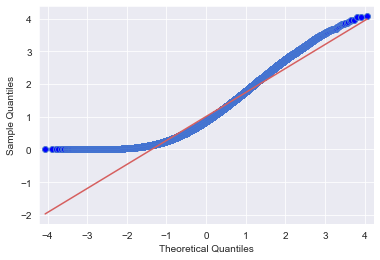

In [166]:
# fitting model to training data
xtrgr.fit(X_train, y_train)

# making predictions on test data 
y_pred = xtrgr.predict(X_test)

# determining how normally distributed error terms are 
fig = sm.qqplot(np.abs(y_test - y_pred),line='s')
plt.show()

### Diabetics

In [167]:
# instantiating ExtraTreesRegressor()
xtrgr = ExtraTreesRegressor(n_estimators=50, random_state=26)

# running extra trees through cross_validate to obtain performance metrics
scores = cross_validate(xtrgr, Xd_train, yd_train, cv=3,
                        scoring=('r2', 'neg_root_mean_squared_error'),
                        return_train_score=True)

In [168]:
# training R-squared
print('Training R-squared Vals:')
print(scores['train_r2'])
print('Mean Training R-squared:')
print(scores['train_r2'].mean(), '\n')

# test R-squared
print('Test R-squared Vals:')
print(scores['test_r2'])
print('Mean Test R-squared:')
print(scores['test_r2'].mean(), '\n')

# root mean square error
print('RMSE Vals:')
print(scores['test_neg_root_mean_squared_error'])
print('Mean RMSE:')
print(scores['test_neg_root_mean_squared_error'].mean())

Training R-squared Vals:
[0.9987067  0.99815225 0.99825423]
Mean Training R-squared:
0.9983710603380033 

Test R-squared Vals:
[-0.23748071 -0.2172453  -0.28349956]
Mean Test R-squared:
-0.24607518671378284 

RMSE Vals:
[-1.0960705  -1.07560164 -1.10682994]
Mean RMSE:
-1.092834025967713


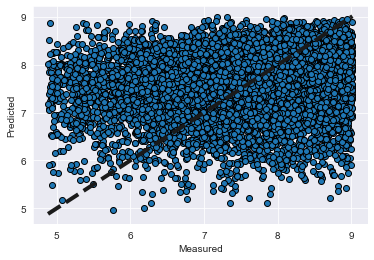

In [169]:
# making predictions with extra trees
predicted = cross_val_predict(xtrgr, Xd_train, yd_train, cv=3)

# displaying plot of measured target values vs. predicted target values
fig, ax = plt.subplots()

ax.scatter(yd_train, predicted, edgecolors=(0, 0, 0))
ax.plot([yd_train.min(), yd_train.max()], [yd_train.min(), yd_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

plt.show()

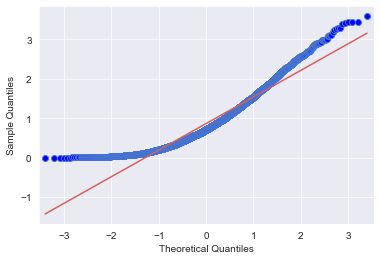

In [170]:
# fitting model to training data
xtrgr.fit(Xd_train, yd_train)

# making predictions on test data 
yd_pred = xtrgr.predict(Xd_test)

# determining how normally distributed error terms are 
fig = sm.qqplot(np.abs(yd_test - yd_pred),line='s')
plt.show()

### Non-Diabetics

In [171]:
# instantiating ExtraTreesRegressor()
xtrgr = ExtraTreesRegressor(n_estimators=50, random_state=26)

# running extra trees through cross_validate to obtain performance metrics
scores = cross_validate(xtrgr, Xnd_train, ynd_train, cv=3,
                        scoring=('r2', 'neg_root_mean_squared_error'),
                        return_train_score=True)

In [172]:
# training R-squared
print('Training R-squared Vals:')
print(scores['train_r2'])
print('Mean Training R-squared:')
print(scores['train_r2'].mean(), '\n')

# test R-squared
print('Test R-squared Vals:')
print(scores['test_r2'])
print('Mean Test R-squared:')
print(scores['test_r2'].mean(), '\n')

# root mean square error
print('RMSE Vals:')
print(scores['test_neg_root_mean_squared_error'])
print('Mean RMSE:')
print(scores['test_neg_root_mean_squared_error'].mean())

Training R-squared Vals:
[0.98143654 0.98316112 0.98171599]
Mean Training R-squared:
0.9821045494803685 

Test R-squared Vals:
[-0.34240551 -0.3336758  -0.3525328 ]
Mean Test R-squared:
-0.3428713693452743 

RMSE Vals:
[-1.24349971 -1.24787914 -1.24778518]
Mean RMSE:
-1.246388010725152


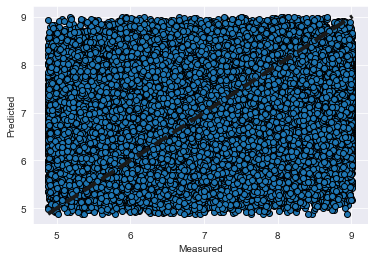

In [173]:
# making predictions with extra trees
predicted = cross_val_predict(xtrgr, Xnd_train, ynd_train, cv=3)

# displaying plot of measured target values vs. predicted target values
fig, ax = plt.subplots()

ax.scatter(ynd_train, predicted, edgecolors=(0, 0, 0))
ax.plot([ynd_train.min(), ynd_train.max()], [ynd_train.min(), ynd_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

plt.show()

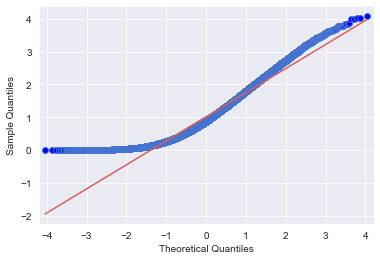

In [174]:
# fitting model to training data
xtrgr.fit(Xnd_train, ynd_train)

# making predictions on test data 
ynd_pred = xtrgr.predict(Xnd_test)

# determining how normally distributed error terms are 
fig = sm.qqplot(np.abs(ynd_test - ynd_pred),line='s')
plt.show()

The increased magnitude in test R-squared from last iteration (0.23 on avg before; 0.3 on avg now) & decreased magnitude in RMSE (1.69 on avg before; 1.29 on avg now) are good signs. But the overall picture is still quite underwhelming, especially if you take a look at the difference between training & test metrics. 

Before moving on from ensemble regression, I make one more attempt after tuning hyperparameters for the extra trees algorithm.

## Tuning Extra Trees Hyperparameters

This subsection performs a grid search through combinations of *n_estimators*, *min_samples_split*, *min_samples_leaf* & *max_features* to find the hyperparameters values that will return the best R-squared metric.

### General

In [175]:
# instantiating ExtraTreesRegressor()
xtrgr = ExtraTreesRegressor(random_state=26)

In [176]:
# a grid of potential parameter values to try out
param_grid = {
    'n_estimators': [50, 75],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 6],
    'max_features': [7, 15]
}

In [177]:
# instantiating & fitting GridSearchCV
grid_search = GridSearchCV(xtrgr, param_grid, scoring='r2', cv=3)
grid_search.fit(X_train, y_train)

# printing grid search results
print(f'Best R-squared: {grid_search.best_score_}')
print('')
print(f'Optimal Parameters: {grid_search.best_params_}')

Best R-squared: 0.10291917164378432

Optimal Parameters: {'max_features': 7, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 75}


### Diabetics

In [178]:
# instantiating ExtraTreesRegressor()
xtrgr = ExtraTreesRegressor(random_state=26)

In [179]:
# a grid of potential parameter values to try out
param_grid = {
    'n_estimators': [50, 75],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 6],
    'max_features': [7, 15]
}

In [180]:
# instantiating & fitting GridSearchCV
grid_search = GridSearchCV(xtrgr, param_grid, scoring='r2', cv=3)
grid_search.fit(Xd_train, yd_train)

# printing grid search results
print(f'Best R-squared: {grid_search.best_score_}')
print('')
print(f'Optimal Parameters: {grid_search.best_params_}')

Best R-squared: 0.07077079360680656

Optimal Parameters: {'max_features': 7, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 50}


### Non-Diabetics

In [181]:
# instantiating ExtraTreesRegressor()
xtrgr = ExtraTreesRegressor(random_state=26)

In [182]:
# a grid of potential parameter values to try out
param_grid = {
    'n_estimators': [50, 75],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 6],
    'max_features': [7, 15]
}

In [183]:
# instantiating & fitting GridSearchCV
grid_search = GridSearchCV(xtrgr, param_grid, scoring='r2', cv=3)
grid_search.fit(Xnd_train, ynd_train)

# printing grid search results
print(f'Best R-squared: {grid_search.best_score_}')
print('')
print(f'Optimal Parameters: {grid_search.best_params_}')

Best R-squared: 0.08360004550885351

Optimal Parameters: {'max_features': 7, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 75}


## Extra Trees with Optimized Hyperparameters

### General

In [184]:
# Optimal Parameters: {'max_features': 7, 'min_samples_leaf': 6,
# 'min_samples_split': 2, 'n_estimators': 75}

# instantiating ExtraTreesRegressor()
xtrgr = ExtraTreesRegressor(max_features=7, min_samples_leaf=6, min_samples_split=2,
                            n_estimators=75, random_state=26)

# running extra trees through cross_validate to obtain performance metrics
scores = cross_validate(xtrgr, X_train, y_train, cv=3,
                        scoring=('r2', 'neg_root_mean_squared_error'),
                        return_train_score=True)

In [185]:
# training R-squared
print('Training R-squared Vals:')
print(scores['train_r2'])
print('Mean Training R-squared:')
print(scores['train_r2'].mean(), '\n')

# test R-squared
print('Test R-squared Vals:')
print(scores['test_r2'])
print('Mean Test R-squared:')
print(scores['test_r2'].mean(), '\n')

# root mean square error
print('RMSE Vals:')
print(scores['test_neg_root_mean_squared_error'])
print('Mean RMSE:')
print(scores['test_neg_root_mean_squared_error'].mean())

Training R-squared Vals:
[0.19720547 0.19686549 0.19561022]
Mean Training R-squared:
0.1965603906275812 

Test R-squared Vals:
[0.102641   0.10455712 0.10155939]
Mean Test R-squared:
0.10291917164378432 

RMSE Vals:
[-1.02684963 -1.01982088 -1.02679093]
Mean RMSE:
-1.024487149390699


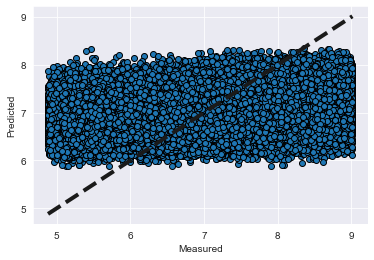

In [186]:
# making predictions with extra trees
predicted = cross_val_predict(xtrgr, X_train, y_train, cv=3)

# displaying plot of measured target values vs. predicted target values
fig, ax = plt.subplots()

ax.scatter(y_train, predicted, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

plt.show()

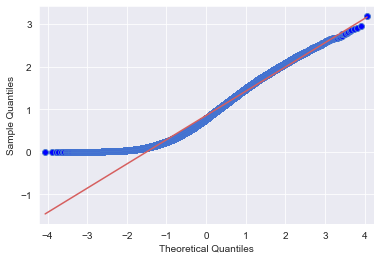

In [187]:
# fitting model to training data
xtrgr.fit(X_train, y_train)

# making predictions on test data 
y_pred = xtrgr.predict(X_test)

# determining how normally distributed error terms are 
fig = sm.qqplot(np.abs(y_test - y_pred),line='s')
plt.show()

### Diabetics

In [188]:
# Optimal Parameters: {'max_features': 7, 'min_samples_leaf': 6, 
# 'min_samples_split': 2, 'n_estimators': 50}

# instantiating ExtraTreesRegressor()
xtrgr = ExtraTreesRegressor(max_features=7, min_samples_leaf=6, min_samples_split=2,
                            n_estimators=50, random_state=26)

# running extra trees through cross_validate to obtain performance metrics
scores = cross_validate(xtrgr, Xd_train, yd_train, cv=3,
                        scoring=('r2', 'neg_root_mean_squared_error'),
                        return_train_score=True)

In [189]:
# training R-squared
print('Training R-squared Vals:')
print(scores['train_r2'])
print('Mean Training R-squared:')
print(scores['train_r2'].mean(), '\n')

# test R-squared
print('Test R-squared Vals:')
print(scores['test_r2'])
print('Mean Test R-squared:')
print(scores['test_r2'].mean(), '\n')

# root mean square error
print('RMSE Vals:')
print(scores['test_neg_root_mean_squared_error'])
print('Mean RMSE:')
print(scores['test_neg_root_mean_squared_error'].mean())

Training R-squared Vals:
[0.22560727 0.21951297 0.21916211]
Mean Training R-squared:
0.22142744852574836 

Test R-squared Vals:
[0.0610774  0.08288206 0.06835292]
Mean Test R-squared:
0.07077079360680656 

RMSE Vals:
[-0.9547379  -0.93363042 -0.94299362]
Mean RMSE:
-0.9437873155522842


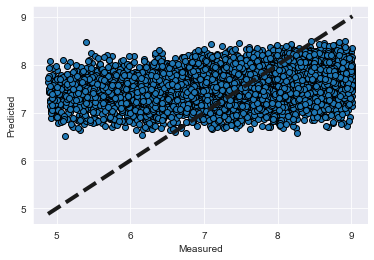

In [190]:
# making predictions with extra trees
predicted = cross_val_predict(xtrgr, Xd_train, yd_train, cv=3)

# displaying plot of measured target values vs. predicted target values
fig, ax = plt.subplots()

ax.scatter(yd_train, predicted, edgecolors=(0, 0, 0))
ax.plot([yd_train.min(), yd_train.max()], [yd_train.min(), yd_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

plt.show()

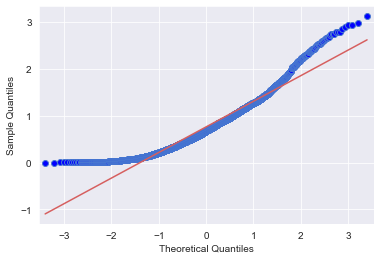

In [191]:
# fitting model to training data
xtrgr.fit(Xd_train, yd_train)

# making predictions on test data 
yd_pred = xtrgr.predict(Xd_test)

# determining how normally distributed error terms are 
fig = sm.qqplot(np.abs(yd_test - yd_pred),line='s')
plt.show()

### Non-Diabetics

In [192]:
# Optimal Parameters: {'max_features': 7, 'min_samples_leaf': 6, 
# 'min_samples_split': 2, 'n_estimators': 75}

# instantiating ExtraTreesRegressor()
xtrgr = ExtraTreesRegressor(max_features=7, min_samples_leaf=6, min_samples_split=2, 
                            n_estimators=75, random_state=26)

# running extra trees through cross_validate to obtain performance metrics
scores = cross_validate(xtrgr, Xnd_train, ynd_train, cv=3,
                        scoring=('r2', 'neg_root_mean_squared_error'),
                        return_train_score=True)

In [193]:
# training R-squared
print('Training R-squared Vals:')
print(scores['train_r2'])
print('Mean Training R-squared:')
print(scores['train_r2'].mean(), '\n')

# test R-squared
print('Test R-squared Vals:')
print(scores['test_r2'])
print('Mean Test R-squared:')
print(scores['test_r2'].mean(), '\n')

# root mean square error
print('RMSE Vals:')
print(scores['test_neg_root_mean_squared_error'])
print('Mean RMSE:')
print(scores['test_neg_root_mean_squared_error'].mean())

Training R-squared Vals:
[0.18248722 0.1807786  0.17762401]
Mean Training R-squared:
0.1802966095657618 

Test R-squared Vals:
[0.0835092  0.08125462 0.08603632]
Mean Test R-squared:
0.08360004550885351 

RMSE Vals:
[-1.02746699 -1.03572623 -1.0257237 ]
Mean RMSE:
-1.0296389745584278


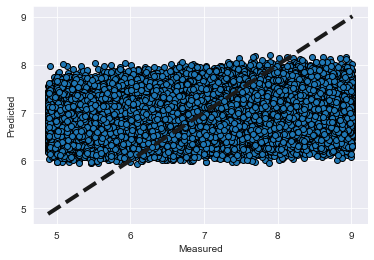

In [194]:
# making predictions with extra trees
predicted = cross_val_predict(xtrgr, Xnd_train, ynd_train, cv=3)

# displaying plot of measured target values vs. predicted target values
fig, ax = plt.subplots()

ax.scatter(ynd_train, predicted, edgecolors=(0, 0, 0))
ax.plot([ynd_train.min(), ynd_train.max()], [ynd_train.min(), ynd_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

plt.show()

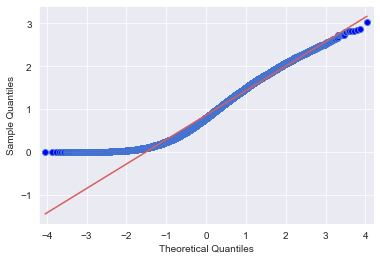

In [195]:
# fitting model to training data
xtrgr.fit(Xnd_train, ynd_train)

# making predictions on test data 
ynd_pred = xtrgr.predict(Xnd_test)

# determining how normally distributed error terms are 
fig = sm.qqplot(np.abs(ynd_test - ynd_pred),line='s')
plt.show()

This iteration exhibited the best improvement on overfitting, as evidenced by the train-test R-squared gap (previously ~+0.98 train to ~-0.23 test on avg; now ~+0.2 train to ~+0.08 test on avg). Additionally, the magnitude of RMSE has dropped from 1.29 on avg before to 0.99 on avg now. Even the Q-Q plot looks better for positive quantile values across the board.

At this point, though, the limits of the ensemble regression approach for this problem have become quite apparent. There seems to be a ceiling on a well fitted R-squared value for this task, and predicting lower target values is a persistent challenge, even after filtering at both ends of the data.

## From Regression to Classification

Since the regression approach has proven unsuccessful, it might help to reconsider the initial premise / question of this project:

**Are the demographic factors (race, sex, education level, income level, age) most important to determining money spent on healthcare the same for diabetics & non-diabetics?**

Though this premise might imply that the answer is only found in a regression model of demographic features & healthcare spending, another modeling approach could lead to a satisfactory answer: classification. Instead of building a regressor that predicts a survey subject's healthcare expenditures (or its logarithm), I could build a classifier that predicts which "tier" of healthcare expenditures a subject falls in. 

Comparing the feature importances between diabetic & non-diabetic subsets of my data is at the heart of this project's question, and I mostly need a well-performing model so that I can make conclusive comparisons between the two groups. Since comparing feature importance is the highest priority, I believe that a classifier could be just as useful for the job as a regressor.

### New Target for Classification: HEALTH_EXPTIER

In this subsection, a new target column *HEALTH_EXPTIER* is created for classification tasks. The classes for the healthcare expenditure target -- "Low," "MedLo," "MedHi," "High" -- are based on quartiles so that the classes are balanced.

In [196]:
# reverting DataFrame df to it's pre-filtered state
df = df_backup

# showing distribution of original target HEALTH_EXP
df['HEALTH_EXP'].describe()

count    204999.000000
mean       3062.226362
std        5003.967390
min           1.000000
25%         362.000000
50%        1137.000000
75%        3349.000000
max       35868.000000
Name: HEALTH_EXP, dtype: float64

In [197]:
# creating healthcare spending bins/categories
bins = [0, 362, 1137, 3349, 35868]
labels = ['Low', 'MedLo', 'MedHi', 'High']

# creating colunn of healthcare spending tiers
df['HEALTH_EXPTIER'] = pd.cut(df['HEALTH_EXP'], bins=bins, labels=labels, include_lowest=True)

# updating df_y & df_n to reflect latest changes
df_y = df.loc[df['DIABDX'] == 1]
df_n = df.loc[df['DIABDX'] == 0]

### Redefining Features/Target for Modeling & Train-Test Split

In [198]:
# assigning features/target, performing train-test split -- general 
X = df[features]
y = df['HEALTH_EXPTIER']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=26)

# encoding categoricals & assembling features for regression -- training set general
train_enc = pd.DataFrame(enc.fit_transform(X_train[categoricals]).toarray(),
                         columns=enc.get_feature_names(categoricals))

X_train = pd.concat([X_train[cont_or_binary].reset_index(drop=True),
                     train_enc.reset_index(drop=True)], axis=1)

# encoding categoricals & assembling features for regression -- test set general
test_enc = pd.DataFrame(enc.transform(X_test[categoricals]).toarray(),
                         columns=enc.get_feature_names(categoricals))

X_test = pd.concat([X_test[cont_or_binary].reset_index(drop=True),
                    test_enc.reset_index(drop=True)], axis=1)

In [199]:
# assigning features/target, performing train-test split -- diabetics 
Xd = df_y[features].drop('DIABDX', axis=1)
yd = df_y['HEALTH_EXPTIER']
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, random_state=26)

# encoding categoricals & assembling features for regression -- training set diabetics
dtrain_enc = pd.DataFrame(enc.fit_transform(Xd_train[categoricals]).toarray(),
                         columns=enc.get_feature_names(categoricals))

Xd_train = pd.concat([Xd_train[cont_or_binary_dia].reset_index(drop=True),
                     dtrain_enc.reset_index(drop=True)], axis=1)

# encoding categoricals & assembling features for regression -- test set diabetics
dtest_enc = pd.DataFrame(enc.transform(Xd_test[categoricals]).toarray(),
                         columns=enc.get_feature_names(categoricals))

Xd_test = pd.concat([Xd_test[cont_or_binary_dia].reset_index(drop=True),
                    dtest_enc.reset_index(drop=True)], axis=1)

In [200]:
# assigning features/target, performing train-test split -- non-diabetics 
Xnd = df_n[features].drop('DIABDX', axis=1)
ynd = df_n['HEALTH_EXPTIER']
Xnd_train, Xnd_test, ynd_train, ynd_test = train_test_split(Xnd, ynd, random_state=26)

# encoding categoricals & assembling features for regression -- training set non-diabetics
ndtrain_enc = pd.DataFrame(enc.fit_transform(Xnd_train[categoricals]).toarray(),
                         columns=enc.get_feature_names(categoricals))

Xnd_train = pd.concat([Xnd_train[cont_or_binary_dia].reset_index(drop=True),
                     ndtrain_enc.reset_index(drop=True)], axis=1)

# encoding categoricals & assembling features for regression -- test set non-diabetics
ndtest_enc = pd.DataFrame(enc.transform(Xnd_test[categoricals]).toarray(),
                         columns=enc.get_feature_names(categoricals))

Xnd_test = pd.concat([Xnd_test[cont_or_binary_dia].reset_index(drop=True),
                    ndtest_enc.reset_index(drop=True)], axis=1)

## Naive Dummy Classifier

I start the classification portion with a naive dummy classifier. This model makes guesses based on the current class distribution, and will serve as a baseline to compare future model performance to. 

### General

In [201]:
# instantiating DummyClassifier()
dummy = DummyClassifier(strategy='stratified', random_state=26)

# running dummy classifier through cross_validate to obtain performance metrics
scores = cross_validate(dummy, X_train, y_train, cv=3,
                        scoring=('accuracy', 'f1_weighted'),
                        return_train_score=True)

In [202]:
# training accuracy
print('Training Accuracy Vals:')
print(scores['train_accuracy'])
print('Mean Accuracy:')
print(scores['train_accuracy'].mean(), '\n')

# test accuracy
print('Test Accuracy Vals:')
print(scores['test_accuracy'])
print('Mean Accuracy:')
print(scores['test_accuracy'].mean(), '\n')

# training f1 (weighted)
print('Training F1 Vals:')
print(scores['train_f1_weighted'])
print('Mean F1:')
print(scores['train_f1_weighted'].mean(), '\n')

# test f1 (weighted)
print('Test F1 Vals:')
print(scores['test_f1_weighted'])
print('Mean F1:')
print(scores['test_f1_weighted'].mean())

Training Accuracy Vals:
[0.25137806 0.24840242 0.24737561]
Mean Accuracy:
0.24905203180645744 

Test Accuracy Vals:
[0.24540488 0.25106341 0.24745849]
Mean Accuracy:
0.24797559322593166 

Training F1 Vals:
[0.251378   0.24840448 0.24737652]
Mean F1:
0.2490529966777432 

Test F1 Vals:
[0.24538442 0.25105056 0.24746752]
Mean F1:
0.24796749987536917


In [203]:
# making predictions with newly fitted dummy classifier
dummy.fit(X_train, y_train)
y_hat_train = dummy.predict(X_train)
y_hat_test = dummy.predict(X_test)

# displaying confusion matrix, classification report, train/test accuracies
print('Confusion matrix for RF:', '\n', confusion_matrix(y_test, y_hat_test))
print(classification_report(y_test, y_hat_test))

Confusion matrix for RF: 
 [[3288 3211 3155 3216]
 [3282 3184 3202 3125]
 [3266 3216 3172 3197]
 [3184 3184 3271 3097]]
              precision    recall  f1-score   support

        High       0.25      0.26      0.25     12870
         Low       0.25      0.25      0.25     12793
       MedHi       0.25      0.25      0.25     12851
       MedLo       0.25      0.24      0.24     12736

    accuracy                           0.25     51250
   macro avg       0.25      0.25      0.25     51250
weighted avg       0.25      0.25      0.25     51250



### Diabetics

In [204]:
# instantiating DummyClassifier()
dummy = DummyClassifier(strategy='stratified', random_state=26)

# running dummy classifier through cross_validate to obtain performance metrics
scores = cross_validate(dummy, Xd_train, yd_train, cv=3,
                        scoring=('accuracy', 'f1_weighted'),
                        return_train_score=True)

In [205]:
# training accuracy
print('Training Accuracy Vals:')
print(scores['train_accuracy'])
print('Mean Accuracy:')
print(scores['train_accuracy'].mean(), '\n')

# test accuracy
print('Test Accuracy Vals:')
print(scores['test_accuracy'])
print('Mean Accuracy:')
print(scores['test_accuracy'].mean(), '\n')

# training f1 (weighted)
print('Training F1 Vals:')
print(scores['train_f1_weighted'])
print('Mean F1:')
print(scores['train_f1_weighted'].mean(), '\n')

# test f1 (weighted)
print('Test F1 Vals:')
print(scores['test_f1_weighted'])
print('Mean F1:')
print(scores['test_f1_weighted'].mean())

Training Accuracy Vals:
[0.35583581 0.35282482 0.35962418]
Mean Accuracy:
0.35609493698463474 

Test Accuracy Vals:
[0.35698393 0.34915925 0.35534125]
Mean Accuracy:
0.353828141779527 

Training F1 Vals:
[0.35684262 0.35384431 0.36066006]
Mean F1:
0.35711566556118096 

Test F1 Vals:
[0.35649709 0.34864217 0.3548424 ]
Mean F1:
0.35332721903646713


In [206]:
# making predictions with newly fitted random forest
dummy.fit(Xd_train, yd_train)
yd_hat_train = dummy.predict(Xd_train)
yd_hat_test = dummy.predict(Xd_test)

# displaying confusion matrix, classification report
print('Confusion matrix for RF:', '\n', confusion_matrix(yd_test, yd_hat_test))
print(classification_report(yd_test, yd_hat_test))

Confusion matrix for RF: 
 [[1010  154  515  311]
 [ 153   25   91   42]
 [ 578   88  335  154]
 [ 329   39  142   79]]
              precision    recall  f1-score   support

        High       0.49      0.51      0.50      1990
         Low       0.08      0.08      0.08       311
       MedHi       0.31      0.29      0.30      1155
       MedLo       0.13      0.13      0.13       589

    accuracy                           0.36      4045
   macro avg       0.25      0.25      0.25      4045
weighted avg       0.35      0.36      0.36      4045



### Non-Diabetics

In [207]:
# instantiating DummyClassifier()
dummy = DummyClassifier(strategy='stratified', random_state=26)

# running dummy classifier through cross_validate to obtain performance metrics
scores = cross_validate(dummy, Xnd_train, ynd_train, cv=3,
                        scoring=('accuracy', 'f1_weighted'),
                        return_train_score=True)

In [208]:
# training accuracy
print('Training Accuracy Vals:')
print(scores['train_accuracy'])
print('Mean Accuracy:')
print(scores['train_accuracy'].mean(), '\n')

# test accuracy
print('Test Accuracy Vals:')
print(scores['test_accuracy'])
print('Mean Accuracy:')
print(scores['test_accuracy'].mean(), '\n')

# training f1 (weighted)
print('Training F1 Vals:')
print(scores['train_f1_weighted'])
print('Mean F1:')
print(scores['train_f1_weighted'].mean(), '\n')

# test f1 (weighted)
print('Test F1 Vals:')
print(scores['test_f1_weighted'])
print('Mean F1:')
print(scores['test_f1_weighted'].mean())

Training Accuracy Vals:
[0.2518801  0.25137168 0.25077852]
Mean Accuracy:
0.25134343113370755 

Test Accuracy Vals:
[0.24967694 0.25202839 0.25024891]
Mean Accuracy:
0.2506514140451223 

Training F1 Vals:
[0.25188046 0.25137358 0.25077802]
Mean F1:
0.2513440200008656 

Test F1 Vals:
[0.24972355 0.25207198 0.25029356]
Mean F1:
0.2506963654421647


In [209]:
# making predictions with newly fitted dummy classifier
dummy.fit(Xnd_train, ynd_train)
ynd_hat_train = dummy.predict(Xnd_train)
ynd_hat_test = dummy.predict(Xnd_test)

# displaying confusion matrix, classification report
print('Confusion matrix for RF:', '\n', confusion_matrix(ynd_test, ynd_hat_test))
print(classification_report(ynd_test, ynd_hat_test))

Confusion matrix for RF: 
 [[2446 2867 2594 2736]
 [2923 3315 3105 3200]
 [2720 3085 2994 3043]
 [2885 3231 2977 3085]]
              precision    recall  f1-score   support

        High       0.22      0.23      0.23     10643
         Low       0.27      0.26      0.26     12543
       MedHi       0.26      0.25      0.25     11842
       MedLo       0.26      0.25      0.25     12178

    accuracy                           0.25     47206
   macro avg       0.25      0.25      0.25     47206
weighted avg       0.25      0.25      0.25     47206



For the general & non-diabetic groups, the overall model accuracy & per-class F1 scores were all right around 0.25, which is expected given the balance between the four target classes. Interestingly, though, the dummy classifier for diabetics has a 0.35 accuracy & much more variation in per-class F1 score. This could be further evidence that healthcare spending for diabetics follows a different pattern than healthcare spending for the general population.

Next, I construct a random forest classifier to see if it outperforms the baseline dummy classifier.

## Random Forest Classifier

### General

In [210]:
# instantiating RandomForestRegressor()
forest = RandomForestClassifier(n_estimators=50, random_state=26)

# running forest through cross_validate to obtain performance metrics
scores = cross_validate(forest, X_train, y_train, cv=3,
                        scoring=('accuracy', 'f1_weighted'),
                        return_train_score=True)

In [211]:
# training accuracy
print('Training Accuracy Vals:')
print(scores['train_accuracy'])
print('Mean Accuracy:')
print(scores['train_accuracy'].mean(), '\n')

# test accuracy
print('Test Accuracy Vals:')
print(scores['test_accuracy'])
print('Mean Accuracy:')
print(scores['test_accuracy'].mean(), '\n')

# training f1 (weighted)
print('Training F1 Vals:')
print(scores['train_f1_weighted'])
print('Mean F1:')
print(scores['train_f1_weighted'].mean(), '\n')

# test f1 (weighted)
print('Test F1 Vals:')
print(scores['test_f1_weighted'])
print('Mean F1:')
print(scores['test_f1_weighted'].mean())

Training Accuracy Vals:
[0.98428277 0.98365838 0.98387317]
Mean Accuracy:
0.9839381071256933 

Test Accuracy Vals:
[0.31160976 0.31336585 0.31313782]
Mean Accuracy:
0.3127044756931208 

Training F1 Vals:
[0.98428443 0.98366039 0.98387498]
Mean F1:
0.9839399316744045 

Test F1 Vals:
[0.31035212 0.31225859 0.31178548]
Mean F1:
0.31146539686452185


In [212]:
# making predictions with newly fitted random forest
forest.fit(X_train, y_train)
y_hat_train = forest.predict(X_train)
y_hat_test = forest.predict(X_test)

# displaying confusion matrix, classification report, train/test accuracies
print('Confusion matrix for RF:', '\n', confusion_matrix(y_test, y_hat_test))
print(classification_report(y_test, y_hat_test))

Confusion matrix for RF: 
 [[4686 2298 3223 2663]
 [2215 4580 2633 3365]
 [3577 2965 3263 3046]
 [2781 3795 2960 3200]]
              precision    recall  f1-score   support

        High       0.35      0.36      0.36     12870
         Low       0.34      0.36      0.35     12793
       MedHi       0.27      0.25      0.26     12851
       MedLo       0.26      0.25      0.26     12736

    accuracy                           0.31     51250
   macro avg       0.31      0.31      0.31     51250
weighted avg       0.31      0.31      0.31     51250



### Diabetics

In [213]:
# instantiating RandomForestRegressor()
forest = RandomForestClassifier(n_estimators=50, random_state=26)

# running forest through cross_validate to obtain performance metrics
scores = cross_validate(forest, Xd_train, yd_train, cv=3,
                        scoring=('accuracy', 'f1_weighted'),
                        return_train_score=True)

In [214]:
# training accuracy
print('Training Accuracy Vals:')
print(scores['train_accuracy'])
print('Mean Accuracy:')
print(scores['train_accuracy'].mean(), '\n')

# test accuracy
print('Test Accuracy Vals:')
print(scores['test_accuracy'])
print('Mean Accuracy:')
print(scores['test_accuracy'].mean(), '\n')

# training f1 (weighted)
print('Training F1 Vals:')
print(scores['train_f1_weighted'])
print('Mean F1:')
print(scores['train_f1_weighted'].mean(), '\n')

# test f1 (weighted)
print('Test F1 Vals:')
print(scores['test_f1_weighted'])
print('Mean F1:')
print(scores['test_f1_weighted'].mean())

Training Accuracy Vals:
[0.99727992 0.99666213 0.99728026]
Mean Accuracy:
0.997074103923883 

Test Accuracy Vals:
[0.4526576  0.45425321 0.46092977]
Mean Accuracy:
0.4559468630397315 

Training F1 Vals:
[0.99727865 0.99666128 0.99727876]
Mean F1:
0.9970728973310191 

Test F1 Vals:
[0.42488778 0.42384471 0.43062528]
Mean F1:
0.42645259122932894


In [215]:
# making predictions with newly fitted random forest
forest.fit(Xd_train, yd_train)
yd_hat_train = forest.predict(Xd_train)
yd_hat_test = forest.predict(Xd_test)

# displaying confusion matrix, classification report
print('Confusion matrix for RF:', '\n', confusion_matrix(yd_test, yd_hat_test))
print(classification_report(yd_test, yd_hat_test))

Confusion matrix for RF: 
 [[1407   73  364  146]
 [ 129   52   87   43]
 [ 669   81  262  143]
 [ 301   63  139   86]]
              precision    recall  f1-score   support

        High       0.56      0.71      0.63      1990
         Low       0.19      0.17      0.18       311
       MedHi       0.31      0.23      0.26      1155
       MedLo       0.21      0.15      0.17       589

    accuracy                           0.45      4045
   macro avg       0.32      0.31      0.31      4045
weighted avg       0.41      0.45      0.42      4045



### Non-Diabetics

In [216]:
# instantiating RandomForestRegressor()
forest = RandomForestClassifier(n_estimators=50, random_state=26)

# running forest through cross_validate to obtain performance metrics
scores = cross_validate(forest, Xnd_train, ynd_train, cv=3,
                        scoring=('accuracy', 'f1_weighted'),
                        return_train_score=True)

In [217]:
# training accuracy
print('Training Accuracy Vals:')
print(scores['train_accuracy'])
print('Mean Accuracy:')
print(scores['train_accuracy'].mean(), '\n')

# test accuracy
print('Test Accuracy Vals:')
print(scores['test_accuracy'])
print('Mean Accuracy:')
print(scores['test_accuracy'].mean(), '\n')

# training f1 (weighted)
print('Training F1 Vals:')
print(scores['train_f1_weighted'])
print('Mean F1:')
print(scores['train_f1_weighted'].mean(), '\n')

# test f1 (weighted)
print('Test F1 Vals:')
print(scores['test_f1_weighted'])
print('Mean F1:')
print(scores['test_f1_weighted'].mean())

Training Accuracy Vals:
[0.98302087 0.98288317 0.98265014]
Mean Accuracy:
0.9828513928609257 

Test Accuracy Vals:
[0.29630336 0.29926915 0.29831586]
Mean Accuracy:
0.2979627864279914 

Training F1 Vals:
[0.98302256 0.98288457 0.98265153]
Mean F1:
0.9828528876893693 

Test F1 Vals:
[0.29559364 0.29808097 0.29732557]
Mean F1:
0.29700005976803323


In [218]:
# making predictions with newly fitted random forest
forest.fit(Xnd_train, ynd_train)
ynd_hat_train = forest.predict(Xnd_train)
ynd_hat_test = forest.predict(Xnd_test)

# displaying confusion matrix, classification report
print('Confusion matrix for RF:', '\n', confusion_matrix(ynd_test, ynd_hat_test))
print(classification_report(ynd_test, ynd_hat_test))

Confusion matrix for RF: 
 [[3269 2178 2782 2414]
 [2031 4652 2574 3286]
 [3027 2853 3044 2918]
 [2463 3620 2817 3278]]
              precision    recall  f1-score   support

        High       0.30      0.31      0.31     10643
         Low       0.35      0.37      0.36     12543
       MedHi       0.27      0.26      0.26     11842
       MedLo       0.28      0.27      0.27     12178

    accuracy                           0.30     47206
   macro avg       0.30      0.30      0.30     47206
weighted avg       0.30      0.30      0.30     47206



Both the accuracies & per-class/average F1 scores are improved across the board, but this random forest has a serious overfitting problem (0.98 training accuracy on avg vs. 0.36 test accuracy on avg). 

Next, I try classification through multinomial logistic regression to see if it will exhibit better fitting.

## Multinomial Logistic Regression

Before jumping into classification with MLR, I have to make sure all input features are scaled between 0 & 1 to prevent overpenalization by L1 regularization. This is mostly a problem for the continuous *AGE* & *TTL_INC* features. In this case, scaling is done with scikit-learn's *MinMaxScaler*. 

In [219]:
# instantiating MinMaxScaler()
mm = MinMaxScaler()

# scaling input features for MLR -- general
X_train_scaled = mm.fit_transform(X_train)
X_test_scaled = mm.transform(X_test)

# scaling input features for MLR -- diabetics
Xd_train_scaled = mm.fit_transform(Xd_train)
Xd_test_scaled = mm.transform(Xd_test)

# scaling input features for MLR -- non-diabetics
Xnd_train_scaled = mm.fit_transform(Xnd_train)
Xnd_test_scaled = mm.transform(Xnd_test)

### General

In [220]:
# creating a multinomial logistic regressor
mlr1 = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000,
                         C=1, penalty='l1', random_state=26)

# performing cross validation 
scores = cross_validate(mlr1, X_train_scaled, y_train, cv=3,
                        scoring=('accuracy', 'f1_weighted'),
                        return_train_score=True)

In [221]:
# training accuracy
print('Training Accuracy Vals:')
print(scores['train_accuracy'])
print('Mean Accuracy:')
print(scores['train_accuracy'].mean(), '\n')

# test accuracy
print('Test Accuracy Vals:')
print(scores['test_accuracy'])
print('Mean Accuracy:')
print(scores['test_accuracy'].mean(), '\n')

# training f1 (weighted)
print('Training F1 Vals:')
print(scores['train_f1_weighted'])
print('Mean F1:')
print(scores['train_f1_weighted'].mean(), '\n')

# test f1 (weighted)
print('Test F1 Vals:')
print(scores['test_f1_weighted'])
print('Mean F1:')
print(scores['test_f1_weighted'].mean())

Training Accuracy Vals:
[0.36617918 0.3638377  0.36611707]
Mean Accuracy:
0.3653779837947259 

Test Accuracy Vals:
[0.36273171 0.36749268 0.36377295]
Mean Accuracy:
0.36466578063708405 

Training F1 Vals:
[0.35312937 0.34950111 0.35349422]
Mean F1:
0.3520415636203256 

Test F1 Vals:
[0.34983764 0.35330964 0.35086355]
Mean F1:
0.3513369422518579


In [222]:
# fitting mlr
mlr1.fit(X_train_scaled, y_train)

# generating predictions
y_hat_train = mlr1.predict(X_train_scaled)
y_hat_test = mlr1.predict(X_test_scaled)

# displaying confusion matrix, classification report of results
print('Confusion matrix for MLR:', '\n', confusion_matrix(y_test, y_hat_test))
print(classification_report(y_test, y_hat_test))

Confusion matrix for MLR: 
 [[5699 2453 2922 1796]
 [1567 7137 1966 2123]
 [3980 3413 3256 2202]
 [2499 5054 2670 2513]]
              precision    recall  f1-score   support

        High       0.41      0.44      0.43     12870
         Low       0.40      0.56      0.46     12793
       MedHi       0.30      0.25      0.28     12851
       MedLo       0.29      0.20      0.24     12736

    accuracy                           0.36     51250
   macro avg       0.35      0.36      0.35     51250
weighted avg       0.35      0.36      0.35     51250



### Diabetics

In [223]:
# creating a multinomial logistic regressor
mlr2 = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000,
                         C=1, penalty='l1', random_state=26)

# performing cross validation 
scores = cross_validate(mlr2, Xd_train_scaled, yd_train, cv=3,
                        scoring=('accuracy', 'f1_weighted'),
                        return_train_score=True)

In [224]:
# training accuracy
print('Training Accuracy Vals:')
print(scores['train_accuracy'])
print('Mean Accuracy:')
print(scores['train_accuracy'].mean(), '\n')

# test accuracy
print('Test Accuracy Vals:')
print(scores['test_accuracy'])
print('Mean Accuracy:')
print(scores['test_accuracy'].mean(), '\n')

# training f1 (weighted)
print('Training F1 Vals:')
print(scores['train_f1_weighted'])
print('Mean F1:')
print(scores['train_f1_weighted'].mean(), '\n')

# test f1 (weighted)
print('Test F1 Vals:')
print(scores['test_f1_weighted'])
print('Mean F1:')
print(scores['test_f1_weighted'].mean())

Training Accuracy Vals:
[0.52423343 0.52268513 0.525034  ]
Mean Accuracy:
0.5239841856608664 

Test Accuracy Vals:
[0.52163164 0.51805143 0.51879327]
Mean Accuracy:
0.5194921174048792 

Training F1 Vals:
[0.41687713 0.40846954 0.41464573]
Mean F1:
0.41333080008343664 

Test F1 Vals:
[0.41544617 0.3990842  0.40949099]
Mean F1:
0.4080071219547725


In [225]:
# fitting mlr
mlr2.fit(Xd_train_scaled, yd_train)

# generating predictions
yd_hat_train = mlr2.predict(Xd_train_scaled)
yd_hat_test = mlr2.predict(Xd_test_scaled)

# displaying confusion matrix, classification report of results
print('Confusion matrix for MLR:', '\n', confusion_matrix(yd_test, yd_hat_test))
print(classification_report(yd_test, yd_hat_test))

Confusion matrix for MLR: 
 [[1905    9   63   13]
 [ 213   23   64   11]
 [1024   19   97   15]
 [ 468   28   75   18]]
              precision    recall  f1-score   support

        High       0.53      0.96      0.68      1990
         Low       0.29      0.07      0.12       311
       MedHi       0.32      0.08      0.13      1155
       MedLo       0.32      0.03      0.06       589

    accuracy                           0.51      4045
   macro avg       0.36      0.29      0.25      4045
weighted avg       0.42      0.51      0.39      4045



### Non-Diabetics

In [226]:
# creating a multinomial logistic regressor
mlr3 = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000,
                         C=1, penalty='l1', random_state=26)

# performing cross validation 
scores = cross_validate(mlr3, Xnd_train_scaled, ynd_train, cv=3,
                        scoring=('accuracy', 'f1_weighted'),
                        return_train_score=True)

In [227]:
# training accuracy
print('Training Accuracy Vals:')
print(scores['train_accuracy'])
print('Mean Accuracy:')
print(scores['train_accuracy'].mean(), '\n')

# test accuracy
print('Test Accuracy Vals:')
print(scores['test_accuracy'])
print('Mean Accuracy:')
print(scores['test_accuracy'].mean(), '\n')

# training f1 (weighted)
print('Training F1 Vals:')
print(scores['train_f1_weighted'])
print('Mean F1:')
print(scores['train_f1_weighted'].mean(), '\n')

# test f1 (weighted)
print('Test F1 Vals:')
print(scores['test_f1_weighted'])
print('Mean F1:')
print(scores['test_f1_weighted'].mean())

Training Accuracy Vals:
[0.35342654 0.3534795  0.35327825]
Mean Accuracy:
0.3533947675034424 

Test Accuracy Vals:
[0.35328885 0.35318293 0.35229319]
Mean Accuracy:
0.35292165377961376 

Training F1 Vals:
[0.34265304 0.34243237 0.34158806]
Mean F1:
0.3422244874757026 

Test F1 Vals:
[0.34253411 0.34211369 0.34071247]
Mean F1:
0.3417867580350937


In [228]:
# fitting mlr
mlr3.fit(Xnd_train_scaled, ynd_train)

# generating predictions
ynd_hat_train = mlr3.predict(Xnd_train_scaled)
ynd_hat_test = mlr3.predict(Xnd_test_scaled)

# displaying confusion matrix, classification report of results
print('Confusion matrix for MLR:', '\n', confusion_matrix(ynd_test, ynd_hat_test))
print(classification_report(ynd_test, ynd_hat_test))

Confusion matrix for MLR: 
 [[3756 2254 2920 1713]
 [1364 7038 1989 2152]
 [3073 3387 3243 2139]
 [2030 4928 2785 2435]]
              precision    recall  f1-score   support

        High       0.37      0.35      0.36     10643
         Low       0.40      0.56      0.47     12543
       MedHi       0.30      0.27      0.28     11842
       MedLo       0.29      0.20      0.24     12178

    accuracy                           0.35     47206
   macro avg       0.34      0.35      0.34     47206
weighted avg       0.34      0.35      0.34     47206



Compared to the random forest classifiers, these MLR models exhibit much better fit between training & test groups for each subset. The 0.35 accuracies for general & non-diabetic groups are a noticeable improvement over the naive 0.25 accuracies, and the 0.52 accuracy for the diabetic group is similarly a noticeable improvement over the naive 0.35 accuracy. The per-class & average F1 scores seem to have improved for the most part as well -- though the per-class F1's in the diabetic group are still all over the place. 

Before settling on round of MLR classification, I see if tuning the penalization hyperparameter improves model performance. 

## MLR with Tuned Hyperparameter C 

For each group, I perform a grid search over 5 different levels of L1 feature penalization (given by the C hyperparameter) to construct a model with the value that returns the best accuracy score.

### General

In [229]:
# creating a multinomial logistic regressor
mlr1 = LogisticRegression(multi_class='multinomial', solver='saga',
                         max_iter=1000, penalty='l1', random_state=26)

# providing list of C-values for gridsearch to iterate through 
grid = {'C': [0.01,0.1,0.5,1,5]}
grid_mlr1 = GridSearchCV(mlr1, param_grid = grid, scoring = 'accuracy')

# performing cross validation 
scores = cross_validate(grid_mlr1, X_train_scaled, y_train, cv=3,
                        scoring=('accuracy', 'f1_weighted'),
                        return_train_score=True)

In [230]:
# training accuracy
print('Training Accuracy Vals:')
print(scores['train_accuracy'])
print('Mean Accuracy:')
print(scores['train_accuracy'].mean(), '\n')

# test accuracy
print('Test Accuracy Vals:')
print(scores['test_accuracy'])
print('Mean Accuracy:')
print(scores['test_accuracy'].mean(), '\n')

# training f1 (weighted)
print('Training F1 Vals:')
print(scores['train_f1_weighted'])
print('Mean F1:')
print(scores['train_f1_weighted'].mean(), '\n')

# test f1 (weighted)
print('Test F1 Vals:')
print(scores['test_f1_weighted'])
print('Mean F1:')
print(scores['test_f1_weighted'].mean())

Training Accuracy Vals:
[0.36633528 0.36390599 0.36611707]
Mean Accuracy:
0.36545278127242486 

Test Accuracy Vals:
[0.36238049 0.36714146 0.36377295]
Mean Accuracy:
0.3644316342956206 

Training F1 Vals:
[0.35325917 0.34959074 0.35349422]
Mean F1:
0.3521147076310838 

Test F1 Vals:
[0.34949186 0.35290204 0.35086355]
Mean F1:
0.3510858175009493


In [231]:
# fitting optimized model to training data
grid_mlr1.fit(X_train_scaled, y_train)

# generating predictions
y_hat_train = grid_mlr1.predict(X_train_scaled)
y_hat_test = grid_mlr1.predict(X_test_scaled)

# displaying confusion matrix, classification report of results
print('Confusion matrix for MLR:', '\n', confusion_matrix(y_test, y_hat_test))
print(classification_report(y_test, y_hat_test))

Confusion matrix for MLR: 
 [[5703 2448 2913 1806]
 [1563 7131 1964 2135]
 [3978 3414 3259 2200]
 [2500 5061 2658 2517]]
              precision    recall  f1-score   support

        High       0.41      0.44      0.43     12870
         Low       0.39      0.56      0.46     12793
       MedHi       0.30      0.25      0.28     12851
       MedLo       0.29      0.20      0.24     12736

    accuracy                           0.36     51250
   macro avg       0.35      0.36      0.35     51250
weighted avg       0.35      0.36      0.35     51250



### Diabetics

In [232]:
# creating a multinomial logistic regressor
mlr2 = LogisticRegression(multi_class='multinomial', solver='saga',
                         max_iter=1000, penalty='l1', random_state=26)

# providing list of C-values for gridsearch to iterate through 
grid = {'C': [0.01,0.1,0.5,1,5]}
grid_mlr2 = GridSearchCV(mlr2, param_grid = grid, scoring = 'accuracy')

# performing cross validation 
scores = cross_validate(grid_mlr2, Xd_train_scaled, yd_train, cv=3,
                        scoring=('accuracy', 'f1_weighted'),
                        return_train_score=True)

In [233]:
# training accuracy
print('Training Accuracy Vals:')
print(scores['train_accuracy'])
print('Mean Accuracy:')
print(scores['train_accuracy'].mean(), '\n')

# test accuracy
print('Test Accuracy Vals:')
print(scores['test_accuracy'])
print('Mean Accuracy:')
print(scores['test_accuracy'].mean(), '\n')

# training f1 (weighted)
print('Training F1 Vals:')
print(scores['train_f1_weighted'])
print('Mean F1:')
print(scores['train_f1_weighted'].mean(), '\n')

# test f1 (weighted)
print('Test F1 Vals:')
print(scores['test_f1_weighted'])
print('Mean F1:')
print(scores['test_f1_weighted'].mean())

Training Accuracy Vals:
[0.52460435 0.52268513 0.52429225]
Mean Accuracy:
0.5238605762703311 

Test Accuracy Vals:
[0.51990111 0.51805143 0.51681503]
Mean Accuracy:
0.5182558604424262 

Training F1 Vals:
[0.41781048 0.40846954 0.40474277]
Mean F1:
0.4103409291603157 

Test F1 Vals:
[0.41273355 0.3990842  0.39815332]
Mean F1:
0.40332368962987464


In [234]:
# fitting optimized model to training data
grid_mlr2.fit(Xd_train_scaled, yd_train)

# generating predictions
yd_hat_train = grid_mlr2.predict(Xd_train_scaled)
yd_hat_test = grid_mlr2.predict(Xd_test_scaled)

# displaying confusion matrix, classification report of results
print('Confusion matrix for MLR:', '\n', confusion_matrix(yd_test, yd_hat_test))
print(classification_report(yd_test, yd_hat_test))

Confusion matrix for MLR: 
 [[1916    2   69    3]
 [ 218   12   80    1]
 [1033   14  106    2]
 [ 473   22   94    0]]
              precision    recall  f1-score   support

        High       0.53      0.96      0.68      1990
         Low       0.24      0.04      0.07       311
       MedHi       0.30      0.09      0.14      1155
       MedLo       0.00      0.00      0.00       589

    accuracy                           0.50      4045
   macro avg       0.27      0.27      0.22      4045
weighted avg       0.36      0.50      0.38      4045



### Non-Diabetics

In [235]:
# creating a multinomial logistic regressor
mlr3 = LogisticRegression(multi_class='multinomial', solver='saga',
                         max_iter=1000, penalty='l1', random_state=26)

# providing list of C-values for gridsearch to iterate through 
grid = {'C': [0.01,0.1,0.5,1,5]}
grid_mlr3 = GridSearchCV(mlr3, param_grid = grid, scoring = 'accuracy')

# performing cross validation 
scores = cross_validate(grid_mlr3, Xnd_train_scaled, ynd_train, cv=3,
                        scoring=('accuracy', 'f1_weighted'),
                        return_train_score=True)

print()

In [236]:
# training accuracy
print('Training Accuracy Vals:')
print(scores['train_accuracy'])
print('Mean Accuracy:')
print(scores['train_accuracy'].mean(), '\n')

# test accuracy
print('Test Accuracy Vals:')
print(scores['test_accuracy'])
print('Mean Accuracy:')
print(scores['test_accuracy'].mean(), '\n')

# training f1 (weighted)
print('Training F1 Vals:')
print(scores['train_f1_weighted'])
print('Mean F1:')
print(scores['train_f1_weighted'].mean(), '\n')

# test f1 (weighted)
print('Test F1 Vals:')
print(scores['test_f1_weighted'])
print('Mean F1:')
print(scores['test_f1_weighted'].mean())

Training Accuracy Vals:
[0.35343714 0.35339477 0.35327825]
Mean Accuracy:
0.35337005260742155 

Test Accuracy Vals:
[0.3533524  0.35358543 0.35229319]
Mean Accuracy:
0.3530770045546023 

Training F1 Vals:
[0.34267514 0.34236474 0.34158806]
Mean F1:
0.34220931407948035 

Test F1 Vals:
[0.34259675 0.34255022 0.34071247]
Mean F1:
0.34195314624022893


In [237]:
# fitting optimized model to training data
grid_mlr3.fit(Xnd_train_scaled, ynd_train)

# generating predictions
ynd_hat_train = grid_mlr3.predict(Xnd_train_scaled)
ynd_hat_test = grid_mlr3.predict(Xnd_test_scaled)

# displaying confusion matrix, classification report of results
print('Confusion matrix for MLR:', '\n', confusion_matrix(ynd_test, ynd_hat_test))
print(classification_report(ynd_test, ynd_hat_test))

Confusion matrix for MLR: 
 [[3739 2250 2935 1719]
 [1359 7042 2003 2139]
 [3062 3385 3255 2140]
 [2014 4933 2801 2430]]
              precision    recall  f1-score   support

        High       0.37      0.35      0.36     10643
         Low       0.40      0.56      0.47     12543
       MedHi       0.30      0.27      0.29     11842
       MedLo       0.29      0.20      0.24     12178

    accuracy                           0.35     47206
   macro avg       0.34      0.35      0.34     47206
weighted avg       0.34      0.35      0.34     47206



Generally, these tuned MLR classifiers perform just about the same as the the classifiers in the previous iteration. Thus, I conclude this project by deriving feature importances from the prior MLR classifiers.

## Feature Importances Derived from Coefficients

Unlike the random forests, decision trees & extra trees, MLR classifiers do not have a built in feature importance method. What they do have, however, is built-in L1 penalization for feature coefficients. I can fit a LogisticRegression model on the dataset and retrieve the coeff_ property that contains the coefficients found for each input feature *for each target classification*. These coefficients can provide the basis for a crude feature importance score. In other words, the higher the magnitude of a feature coefficient, less penalized & the more "important" it is.  

Since these coefficients are provided by target class, my strategy here is to find which features have a coefficient magnitude of at least 0.1 across all target classes within a modeling group. These features will be deemed most important.

### General

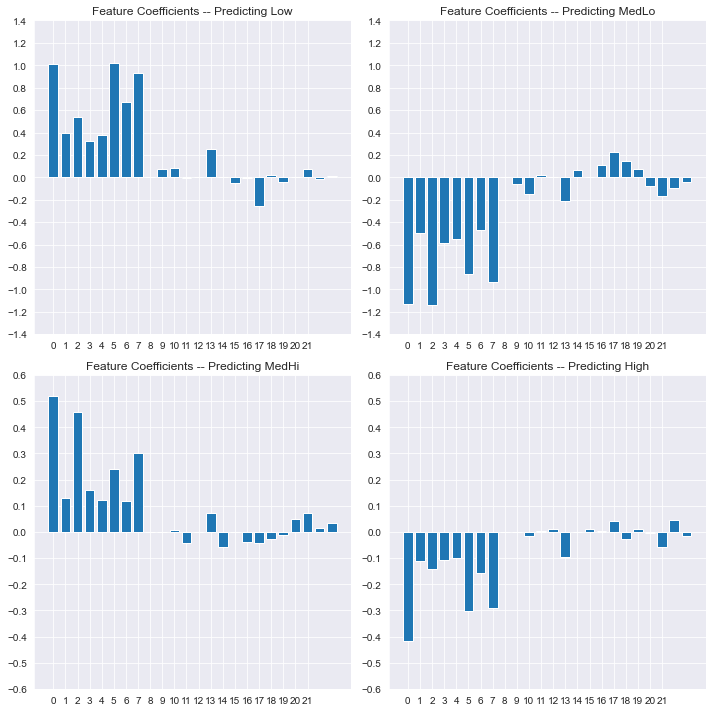

In [239]:
# fitting MLR model to obtain coefficients
mlr1.fit(X_train_scaled, y_train)

# plotting coefficient values after penalization for each target category
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

ax[0, 0].bar([x for x in range(len(mlr1.coef_[0]))],
              mlr1.coef_[0])
ax[0, 0].set_title('Feature Coefficients -- Predicting Low')
ax[0, 0].set_ylim(bottom=-1.4, top=1.4)
ax[0, 0].set_yticks(np.linspace(-1.4,1.4,15))
ax[0, 0].set_xticks(np.linspace(0,21,22))

ax[0, 1].bar([x for x in range(len(mlr1.coef_[1]))],
              mlr1.coef_[1])
ax[0, 1].set_title('Feature Coefficients -- Predicting MedLo')
ax[0, 1].set_ylim(bottom=-1.4, top=1.4)
ax[0, 1].set_yticks(np.linspace(-1.4,1.4,15))
ax[0, 1].set_xticks(np.linspace(0,21,22))

ax[1, 0].bar([x for x in range(len(mlr1.coef_[2]))],
              mlr1.coef_[2])
ax[1, 0].set_title('Feature Coefficients -- Predicting MedHi')
ax[1, 0].set_ylim(bottom=-.6, top=.6)
ax[1, 0].set_yticks(np.linspace(-.6,.6,13))
ax[1, 0].set_xticks(np.linspace(0,21,22))

ax[1, 1].bar([x for x in range(len(mlr1.coef_[3]))],
              mlr1.coef_[3])
ax[1, 1].set_title('Feature Coefficients -- Predicting High')
ax[1, 1].set_ylim(bottom=-.6, top=.6)
ax[1, 1].set_yticks(np.linspace(-.6,.6,13))
ax[1, 1].set_xticks(np.linspace(0,21,22))

fig.tight_layout()

In [240]:
# key for x-axis values
print(dict(zip(range(len(mlr1.coef_[0])),
               X_train.columns[mlr1.coef_[0] == mlr1.coef_[0]])))

{0: 'AGE', 1: 'SEX', 2: 'TTL_INC', 3: 'INS_PRV', 4: 'INS_TRI', 5: 'INS_MCR', 6: 'INS_MCD', 7: 'DIABDX', 8: 'REGION_-1', 9: 'REGION_1', 10: 'REGION_2', 11: 'REGION_3', 12: 'REGION_4', 13: 'RACETHX_0', 14: 'RACETHX_1', 15: 'RACETHX_2', 16: 'EDU_LVL_-1.0', 17: 'EDU_LVL_1.0', 18: 'EDU_LVL_2.0', 19: 'EDU_LVL_3.0', 20: 'EDU_LVL_4.0', 21: 'EDU_LVL_5.0', 22: 'EDU_LVL_6.0', 23: 'EDU_LVL_7.0'}


Features that have coefficients w/ absolute value > 0.1 across all tiers: Age, Sex, Income, Ins_Prv, Ins_Tri, Ins_Mcr, Ins_Mcd, Diabetic (3rd most important feature at all tiers) 

### Diabetics

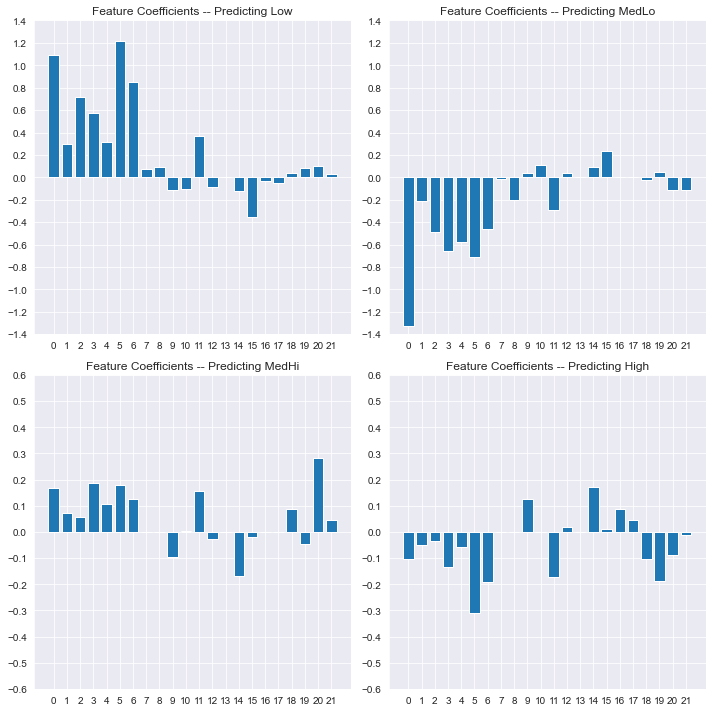

In [241]:
# fitting MLR model to obtain coefficients
mlr2.fit(Xd_train_scaled, yd_train)

# plotting coefficient values after penalization for each target category
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

ax[0, 0].bar([x for x in range(len(mlr2.coef_[0]))],
              mlr2.coef_[0])
ax[0, 0].set_title('Feature Coefficients -- Predicting Low')
ax[0, 0].set_ylim(bottom=-1.4, top=1.4)
ax[0, 0].set_yticks(np.linspace(-1.4,1.4,15))
ax[0, 0].set_xticks(np.linspace(0,21,22))

ax[0, 1].bar([x for x in range(len(mlr2.coef_[1]))],
              mlr2.coef_[1])
ax[0, 1].set_title('Feature Coefficients -- Predicting MedLo')
ax[0, 1].set_ylim(bottom=-1.4, top=1.4)
ax[0, 1].set_yticks(np.linspace(-1.4,1.4,15))
ax[0, 1].set_xticks(np.linspace(0,21,22))

ax[1, 0].bar([x for x in range(len(mlr2.coef_[2]))],
              mlr2.coef_[2])
ax[1, 0].set_title('Feature Coefficients -- Predicting MedHi')
ax[1, 0].set_ylim(bottom=-.6, top=.6)
ax[1, 0].set_yticks(np.linspace(-.6,.6,13))
ax[1, 0].set_xticks(np.linspace(0,21,22))

ax[1, 1].bar([x for x in range(len(mlr2.coef_[3]))],
              mlr2.coef_[3])
ax[1, 1].set_title('Feature Coefficients -- Predicting High')
ax[1, 1].set_ylim(bottom=-.6, top=.6)
ax[1, 1].set_yticks(np.linspace(-.6,.6,13))
ax[1, 1].set_xticks(np.linspace(0,21,22))

fig.tight_layout()

In [242]:
# key for x-axis values
print(dict(zip(range(len(mlr2.coef_[0])),
               Xd_train.columns[mlr2.coef_[0] == mlr2.coef_[0]])))

{0: 'AGE', 1: 'SEX', 2: 'TTL_INC', 3: 'INS_PRV', 4: 'INS_TRI', 5: 'INS_MCR', 6: 'INS_MCD', 7: 'REGION_1', 8: 'REGION_2', 9: 'REGION_3', 10: 'REGION_4', 11: 'RACETHX_0', 12: 'RACETHX_1', 13: 'RACETHX_2', 14: 'EDU_LVL_-1.0', 15: 'EDU_LVL_1.0', 16: 'EDU_LVL_2.0', 17: 'EDU_LVL_3.0', 18: 'EDU_LVL_4.0', 19: 'EDU_LVL_5.0', 20: 'EDU_LVL_6.0', 21: 'EDU_LVL_7.0'}


Features that have coefficients w/ absolute value > 0.1 across all tiers: Age, Ins_Prv, Ins_Mcr, Ins_Mcd, Race "Other"

### Non-Diabetics

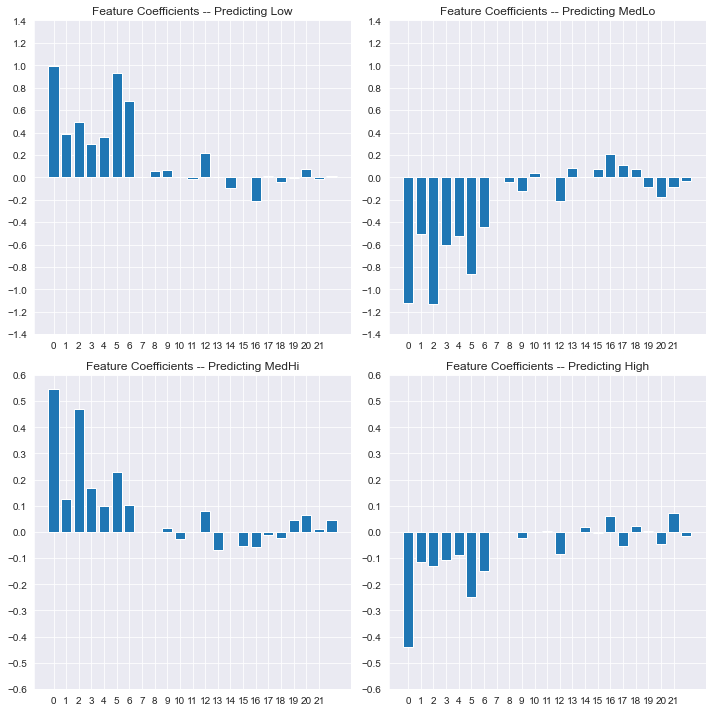

In [244]:
# fitting MLR model to obtain coefficients
mlr3.fit(Xnd_train_scaled, ynd_train)

# plotting coefficient values after penalization for each target category
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

ax[0, 0].bar([x for x in range(len(mlr3.coef_[0]))],
              mlr3.coef_[0])
ax[0, 0].set_title('Feature Coefficients -- Predicting Low')
ax[0, 0].set_ylim(bottom=-1.4, top=1.4)
ax[0, 0].set_yticks(np.linspace(-1.4,1.4,15))
ax[0, 0].set_xticks(np.linspace(0,21,22))

ax[0, 1].bar([x for x in range(len(mlr3.coef_[1]))],
              mlr3.coef_[1])
ax[0, 1].set_title('Feature Coefficients -- Predicting MedLo')
ax[0, 1].set_ylim(bottom=-1.4, top=1.4)
ax[0, 1].set_yticks(np.linspace(-1.4,1.4,15))
ax[0, 1].set_xticks(np.linspace(0,21,22))

ax[1, 0].bar([x for x in range(len(mlr3.coef_[2]))],
              mlr3.coef_[2])
ax[1, 0].set_title('Feature Coefficients -- Predicting MedHi')
ax[1, 0].set_ylim(bottom=-.6, top=.6)
ax[1, 0].set_yticks(np.linspace(-.6,.6,13))
ax[1, 0].set_xticks(np.linspace(0,21,22))

ax[1, 1].bar([x for x in range(len(mlr3.coef_[3]))],
              mlr3.coef_[3])
ax[1, 1].set_title('Feature Coefficients -- Predicting High')
ax[1, 1].set_ylim(bottom=-.6, top=.6)
ax[1, 1].set_yticks(np.linspace(-.6,.6,13))
ax[1, 1].set_xticks(np.linspace(0,21,22))

fig.tight_layout()

In [245]:
# key for x-axis values
print(dict(zip(range(len(mlr3.coef_[0])),
               Xnd_train.columns[mlr3.coef_[0] == mlr3.coef_[0]])))

{0: 'AGE', 1: 'SEX', 2: 'TTL_INC', 3: 'INS_PRV', 4: 'INS_TRI', 5: 'INS_MCR', 6: 'INS_MCD', 7: 'REGION_-1', 8: 'REGION_1', 9: 'REGION_2', 10: 'REGION_3', 11: 'REGION_4', 12: 'RACETHX_0', 13: 'RACETHX_1', 14: 'RACETHX_2', 15: 'EDU_LVL_-1.0', 16: 'EDU_LVL_1.0', 17: 'EDU_LVL_2.0', 18: 'EDU_LVL_3.0', 19: 'EDU_LVL_4.0', 20: 'EDU_LVL_5.0', 21: 'EDU_LVL_6.0', 22: 'EDU_LVL_7.0'}


Features that have coefficients w/ absolute value > 0.1 across all tiers: Age, Sex, Income, Ins_Prv, Ins_Mcr, Ins_Mcd

# Conclusion

This project began with a lengthy inspection, adjustment & standardization of column values across all 19 years (2000-2018). After this preprocessing phase, I performed exploratory data analysis (EDA) & constructed visualizations for the columns in my dataset. This provided some valuable insight into relationships between certain demographic factors & healthcare spending for both diabetic and non-diabetic survey subjects. 

In particular, the lineplot of median healthcare spending for both groups over time was quite illuminating. Explorations of the relationships between age group & healthcare spending, as well as income & healthcare spending, were insightful as well.

After the processing, EDA & visualizing, I moved on to iterative modeling. For all but one of the algorithms used in this section, 3 separate models were constructed:

* *General*: Included data on both diabetics & non-diabetics. This model's purpose was to let me know how important having diabetes was in determining the degree of healthcare cost.

* *Diabetics*: Only included data on diabetic survey subjects. This model's purpose was to let me know which demographic features were most important in determining the degree of healthcare costs for diabetics.

* *Non-Diabetics*: Only included data on non-diabetic survey subjects. This model's purpose was to let me know which demographic features were most important in determining the degree of healthcare costs for non-diabetics.

I began by performing regression tasks, with the demographic data as the input features & the logarithm of annual healthcare spending as the target. Regression began with a baseline decision tree, to which I could compare the performance of subsequent regressors.

After evaulating the performance of these regressors, however, it became apparent that none of them were reliable enough predictors to draw conclusions from. All of them were prone to drastic overfitting, and those that didn't overfit were unable to return satisfactory R-squared values. 

Subsequently, I re-oriented my modeling goal from regression to classification, turning the original healthcare spending target into a categorical target consisting of spending tiers (based on quartile values). To begin this section, I ran a naive dummy classifier that made guesses based on class distribution. 

Ultimately, my best results came from using multionimial logistic regression (MLR) to classify the healthcare spending tier. The MLR models exhibited the best fitting from training to test data, and consistently had accuracy scores from 35-50%. At the very least, these metrics were a significant improvment over the naive classifier. 

These were my conclusions drawn from the MLR feature coefficients: 

* *General*: **whether subject had diabetes was the 3rd most important feature** (behind age, having a Medicare plan) in determining degree of healthcare spending.

* *Diabetics*: features that were significant in predicting degree of healthcare spending -- subject's **age**.

* *Non-Diabetics*: features that were significant in predicting degree of healthcare spending -- subject's **age**, **sex**, **income**.

Finally, to address the initial problem's main question: the most impactful factor on healthcare spending for both groups is a person's age. As seen in EDA & visualization, though, healthcare spending increases more rapidly over time for diabetics. 

# Recommendations

Based on this conclusion, I recommend that Beyond Type I:

* Direct fundraising efforts toward poorer middle-age diabetics, whose income might not keep up with rising healthcare costs over time.
* Make an organization-wide push to recruit more middle-age diabetics into their advocacy efforts. 
* Create education programs for older citizens that ensure they maintain healthy habits & keep them up to date on the latest diabetes management technology.

# Future Work

Given more time with the job, I would:

* Obtain similar data that has a more thorough time component in order to perform time series based speculation about future healthcare costs.
* Obtain healthcare spending data for US residents with other specific conditions to observe how much they spend compared to diabetics. 
* Make comparison of diabetes healthcare costs for US residents vs residents of other nations around the world.